## This is where I do all of my verification

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from datetime import datetime, timedelta
import cmocean

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow.python.keras.optimizer_v2.adam import Adam
tfd = tfp.distributions
import tensorflow.keras.backend as K
from tensorflow import math as tfm

import os

import utilsProb
import utilsProbSS
import glob
import sys
from scipy.stats import rankdata
import pandas as pd
import importlib
import copy
from netCDF4 import Dataset, num2date
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context("paper")
import properscoring as ps
from math import erf
import xarray as xr

import matplotlib
#mapping
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import Unet_b
import utils_CNN
from tensorflow.python.client import device_lib
import xarray as xr

import coms
import utilsAnEn
import utils_verif
import comsnn
from sklearn.metrics import brier_score_loss
from tqdm import tqdm

import sklearn

/glade/work/wchapman/miniconda3/envs/tfp/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Define my color pallete

In [2]:
mycolors = {'$GEFS_{nn}$':[0.7561707035755478, 0.21038062283737025, 0.22352941176470587], 
            '$MV_gefs$':[0.940715109573241, 0.6099192618223759, 0.4812764321414839],
            '$GEFS$':[0.9838523644752019, 0.8089965397923875, 0.7167243367935409],
            '$CNN$':[1,1,1],
            '$CNNft_ref$': [1,1,1],
            '$NN$': [0.530026912725875, 0.7456362937331797, 0.8560553633217994],
            '$AnEn$': [0.1843137254901961, 0.47266435986159167, 0.7116493656286044],
            '$FCN$': [0.0196078431372549, 0.18823529411764706, 0.3803921568627451]}


SScolors = {'$GEFS_{nn}$':[0.7561707035755478, 0.21038062283737025, 0.22352941176470587], 
            '$MV_gefs$':[0.940715109573241, 0.6099192618223759, 0.4812764321414839],
            '$GEFS$':[0.9838523644752019, 0.8089965397923875, 0.7167243367935409],
            '$CNN$':[0,0,0],
            '$CNNft_ref$': [0,0,0],
            '$NN$': [0.530026912725875, 0.7456362937331797, 0.8560553633217994],
            '$AnEn$': [0.1843137254901961, 0.47266435986159167, 0.7116493656286044],
            '$FCN$': [0.0196078431372549, 0.18823529411764706, 0.3803921568627451]}

#boxplot dict
BPdict = {'tickFS':30,'labelFS':35,'titleFS':35,'legendFS':25,'FigSize':np.array([40,10])}

#spread/skill dict
SSdict = {'tickFS':25,'labelFS':25,'titleFS':35,'legendFS':25,'FigSize':np.array([15,10])}

#RankHist dict
RHdict = {'tickFS':25,'labelFS':25,'titleFS':35,'legendFS':25,'FigSize':np.array([20, 6])}

In [3]:
importlib.reload(utils_verif)
importlib.reload(utilsAnEn)

<module 'utilsAnEn' from '/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/utilsAnEn.py'>

# Figure 2.

In [44]:
dffin=pd.DataFrame({'Lead':[],'Model':[],'RMSE':[]})
fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,126,12)]
bsnummy = 1000

df1, df2, dfm = 1,1,1


for fcast in fcasts:
    print('doing:',fcast)
    ########################################################################################################
    del df1
    del df2
    del dfm
    mod = 'NN_gefs'
    df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})
    

    mod = 'Reforecast'
    df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df2['lon']=df2['lon']+360
    
    dfm = pd.merge(df1,df2,how='left')
    bp_ref = np.zeros([bsnummy])
    cor_ref = np.zeros([bsnummy])
    for aa in range(bsnummy):
        inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
    
        bp_ref[aa]=(1 - (utils_verif.rmse(dfm['IVTmean_gefs'][inss],dfm['OBSnn'][inss]))/(utils_verif.rmse(dfm['Reforecast'][inss],dfm['OBScnn'][inss])))*100
        cor_ref[aa]=(1 - (utils_verif.corrss(dfm['IVTmean_gefs'][inss],dfm['OBSnn'][inss]))/(utils_verif.corrss(dfm['Reforecast'][inss],dfm['OBScnn'][inss])))*100
        
    dftemp = pd.DataFrame({'Corr':cor_ref})
    dftemp['Lead'] = fcast
    dftemp['RMSE'] = bp_ref
    dftemp['Model'] = '$GEFS_{nn}$'
    dffin = pd.concat([dffin, dftemp], axis=0)
    
    ########################################################################################################    
    
    del df1
    del df2
    del dfm
    mod = 'Raw_gefs'
    df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})
    

    mod = 'Reforecast'
    df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df2['lon']=df2['lon']+360

    dfm = pd.merge(df1,df2,how='left')

    bp_ref = np.zeros([bsnummy])
    cor_ref = np.zeros([bsnummy])
    for aa in range(bsnummy):
        inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
    
        bp_ref[aa]=(1 - (utils_verif.rmse(dfm['IVTmean_gefs'][inss],dfm['OBSnn'][inss]))/(utils_verif.rmse(dfm['Reforecast'][inss],dfm['OBScnn'][inss])))*100
        cor_ref[aa]=(1 - (utils_verif.corrss(dfm['IVTmean_gefs'][inss],dfm['OBSnn'][inss]))/(utils_verif.corrss(dfm['Reforecast'][inss],dfm['OBScnn'][inss])))*100
        
    dftemp = pd.DataFrame({'Corr':cor_ref})
    dftemp['Lead'] = fcast
    dftemp['RMSE'] = bp_ref
    dftemp['Model'] = '$GEFS$'
    dffin = pd.concat([dffin, dftemp], axis=0)
    
    ########################################################################################################
    del df1
    del df2
    del dfm
    mod = 'Reforecast'
    df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df1 = df1.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df1['lon']=df1['lon']+360

    mod = 'CNNft_ref'
    df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df2['lon']=df2['lon']+360

    dfm = pd.merge(df1,df2,how='left')

    bp_cnn = np.zeros([bsnummy])
    cor_cnn= np.zeros([bsnummy])
    for aa in range(bsnummy):
        inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
    
        bp_cnn[aa]=(1 - (utils_verif.rmse(dfm['IVTmean_cnn'][inss],dfm['OBScnn'][inss]))/(utils_verif.rmse(dfm['Reforecast'][inss],dfm['OBScnn'][inss])))*100
        cor_cnn[aa]=(1 - (utils_verif.corrss(dfm['IVTmean_cnn'][inss],dfm['OBScnn'][inss]))/(utils_verif.corrss(dfm['Reforecast'][inss],dfm['OBScnn'][inss])))*100
    
    
    dftemp = pd.DataFrame({'Corr':cor_cnn})
    dftemp['RMSE'] = bp_cnn
    dftemp['Lead'] = fcast
    dftemp['Model'] = '$CNN$'
    dffin = pd.concat([dffin, dftemp], axis=0)
    
    ########################################################################################################
    del df1
    del df2
    del dfm
    mod = 'NN_gefs'
    df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

    mod = 'NNft_ref'
    df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df2 = df2.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
    df2['lon']=df2['lon']+360

    dfm = pd.merge(df1,df2,how='left')

    bp_nn = np.zeros([bsnummy])
    cor_nn = np.zeros([bsnummy])
    for aa in range(bsnummy):
        inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
    
        bp_nn[aa]=(1 - (utils_verif.rmse(dfm['IVTmean_nn'][inss],dfm['OBSnn'][inss]))/(utils_verif.rmse(dfm['Reforecast'][inss],dfm['OBSnn'][inss])))*100
        cor_nn[aa]=(1 - (utils_verif.corrss(dfm['IVTmean_nn'][inss],dfm['OBSnn'][inss]))/(utils_verif.corrss(dfm['Reforecast'][inss],dfm['OBSnn'][inss])))*100

    dftemp = pd.DataFrame({'Corr':cor_nn})
    dftemp['RMSE'] = bp_nn
    dftemp['Lead'] = fcast
    dftemp['Model'] = '$NN$'
    dffin = pd.concat([dffin, dftemp], axis=0)
    
    
    
    ########################################################################################################
    del df1
    del df2
    del dfm
    
    mod = 'NN_gefs'
    df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

    mod = 'AnEn'
    df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df2 = df2.rename(columns={'OBS':'OBSanen','Model':'Reforecast','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
    df2['Mean'] = np.mean(df2.filter(regex='Analog'),axis=1)
    df2['time']= df2['Issued_Time']+ timedelta(hours=int(fcast[-3:]))

    dfm = pd.merge(df1,df2,how='left')
    
    bp_anen = np.zeros([bsnummy])
    corr_anen = np.zeros([bsnummy])
    for aa in range(bsnummy):
        inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
    
        bp_anen[aa]=(1 - (utils_verif.rmse(dfm['Mean'][inss],dfm['OBSanen'][inss]))/(utils_verif.rmse(dfm['Reforecast'][inss],dfm['OBSnn'][inss])))*100
        corr_anen[aa]=(1 - (utils_verif.corrss(dfm['Mean'][inss],dfm['OBSanen'][inss]))/(utils_verif.corrss(dfm['Reforecast'][inss],dfm['OBSnn'][inss])))*100
    
    
    dftemp = pd.DataFrame({'Corr':corr_anen})
    dftemp['RMSE'] = bp_anen
    dftemp['Lead'] = fcast
    dftemp['Model'] = '$AnEn$'
    dffin = pd.concat([dffin, dftemp], axis=0)
    
    print(dffin.shape)
    ########################################################################################################
    del df1
    del df2
    del dfm
    mod = 'Reforecast'
    df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df1 = df1.rename(columns={'OBS':'OBSemos','Model':'Reforecast1','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
    df1['lon']=df1['lon']+360

    mod = 'EMOS'
    df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    df2 = df2.rename(columns={'OBS':'OBSemos','Model':'Reforecast','IVTmean':'IVTmean_emos','IVTstd':'IVTstd_emos'})
    df2['lon']=df2['lon']+360

    dfm = pd.merge(df1,df2,how='left')

    bp_emos = np.zeros([bsnummy])
    cor_emos= np.zeros([bsnummy])
    for aa in range(bsnummy):
        inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
    
        bp_emos[aa]=(1 - (utils_verif.rmse(dfm['IVTmean_emos'][inss],dfm['OBSemos'][inss]))/(utils_verif.rmse(dfm['Reforecast'][inss],dfm['OBSemos'][inss])))*100
        cor_emos[aa]=(1 - (utils_verif.corrss(dfm['IVTmean_emos'][inss],dfm['OBSemos'][inss]))/(utils_verif.corrss(dfm['Reforecast'][inss],dfm['OBSemos'][inss])))*100
    
    
    dftemp = pd.DataFrame({'Corr':cor_emos})
    dftemp['RMSE'] = bp_emos
    dftemp['Lead'] = fcast
    dftemp['Model'] = '$FCN$'
    dffin = pd.concat([dffin, dftemp], axis=0)
    
    

dffin['Corr'] = -dffin['Corr']

doing: F000
No Post-Processing
2016
2017
2018
(5000, 4)
doing: F012
No Post-Processing
2016
2017
2018
(11000, 4)
doing: F024
No Post-Processing
2016
2017
2018
(17000, 4)
doing: F036
No Post-Processing
2016
2017
2018
(23000, 4)
doing: F048
No Post-Processing
2016
2017
2018
(29000, 4)
doing: F060
No Post-Processing
2016
2017
2018
(35000, 4)
doing: F072
No Post-Processing
2016
2017
2018
(41000, 4)
doing: F084
No Post-Processing
2016
2017
2018
(47000, 4)
doing: F096
No Post-Processing
2016
2017
2018
(53000, 4)
doing: F108
No Post-Processing
2016
2017
2018
(59000, 4)
doing: F120
No Post-Processing
2016
2017
2018
(65000, 4)


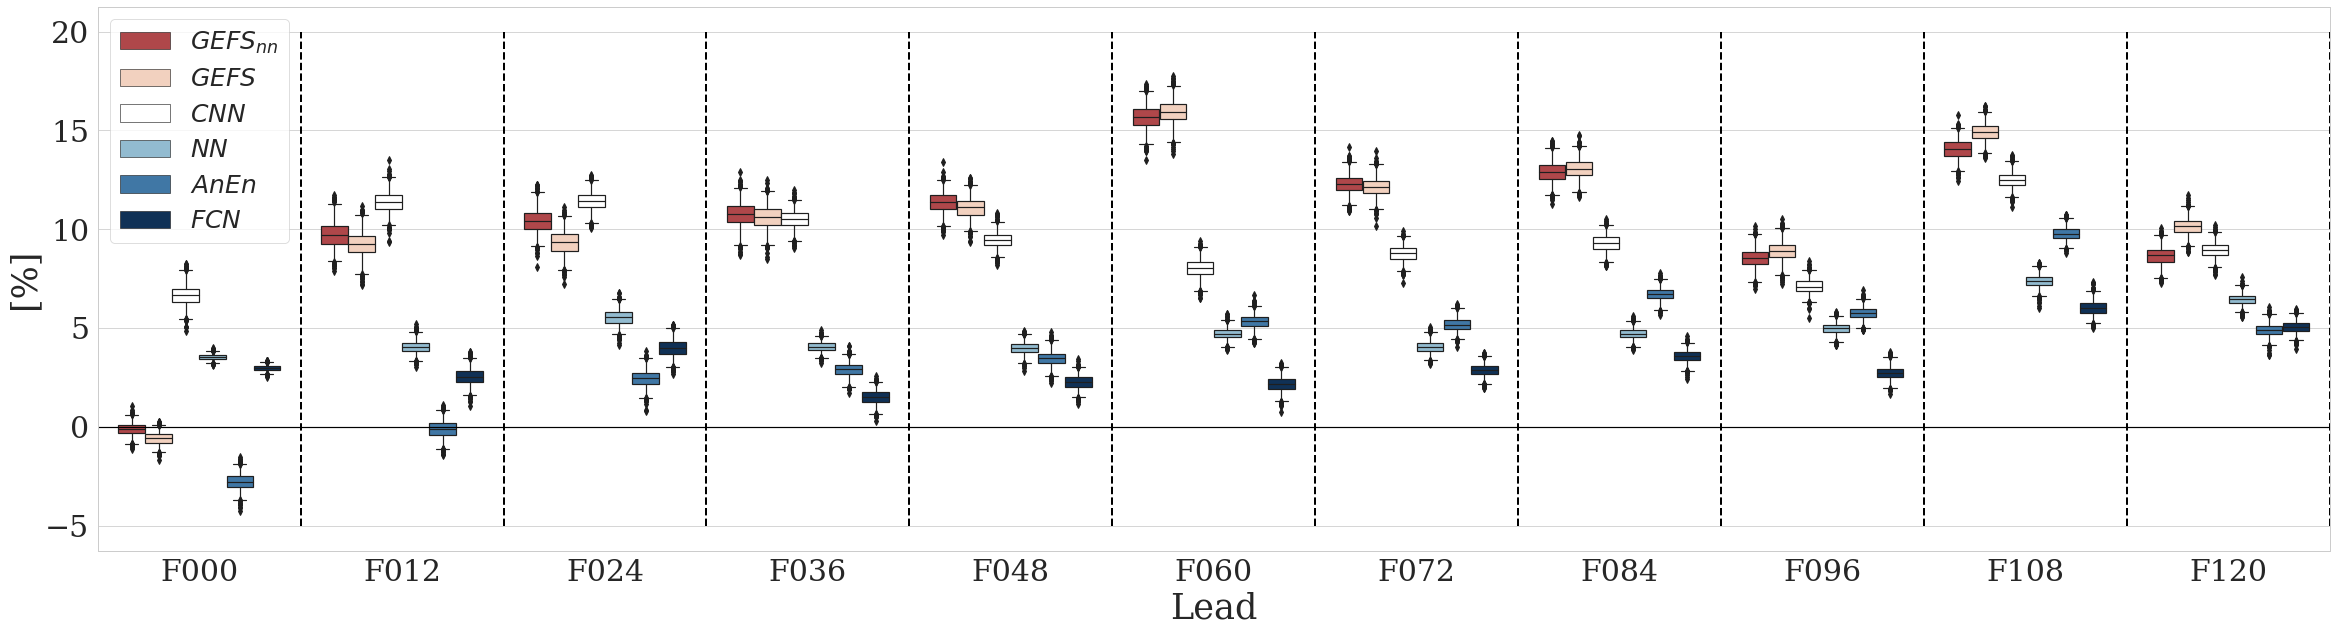

In [45]:

sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context("paper")

plt.figure(figsize=BPdict['FigSize'])
plt.plot([-10,23],[0,0],'k')

ax = sns.boxplot(x="Lead", y="RMSE", hue="Model",data=dffin, palette= mycolors,whis=[1,99])
plt.yticks(fontsize=BPdict['tickFS'])
plt.xticks(fontsize=BPdict['tickFS'])
plt.ylabel('[%]',fontsize=BPdict['labelFS'])
# plt.title('RMSE [Kg m-1 s-1]',fontsize=BPdict['titleFS'])
plt.xlabel('Lead',fontsize=BPdict['labelFS'])
plt.legend(fontsize=BPdict['legendFS'])

for bb in np.arange(-.5,22,1):
    plt.plot([bb,bb],[-5,20],'k--',linewidth=2)

# plt.ylim([-20,20])
plt.xlim([-0.5,10.5])
plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RMSElead_Tot_FINAL.png',dpi = 300,bbox_inches='tight')
plt.show()

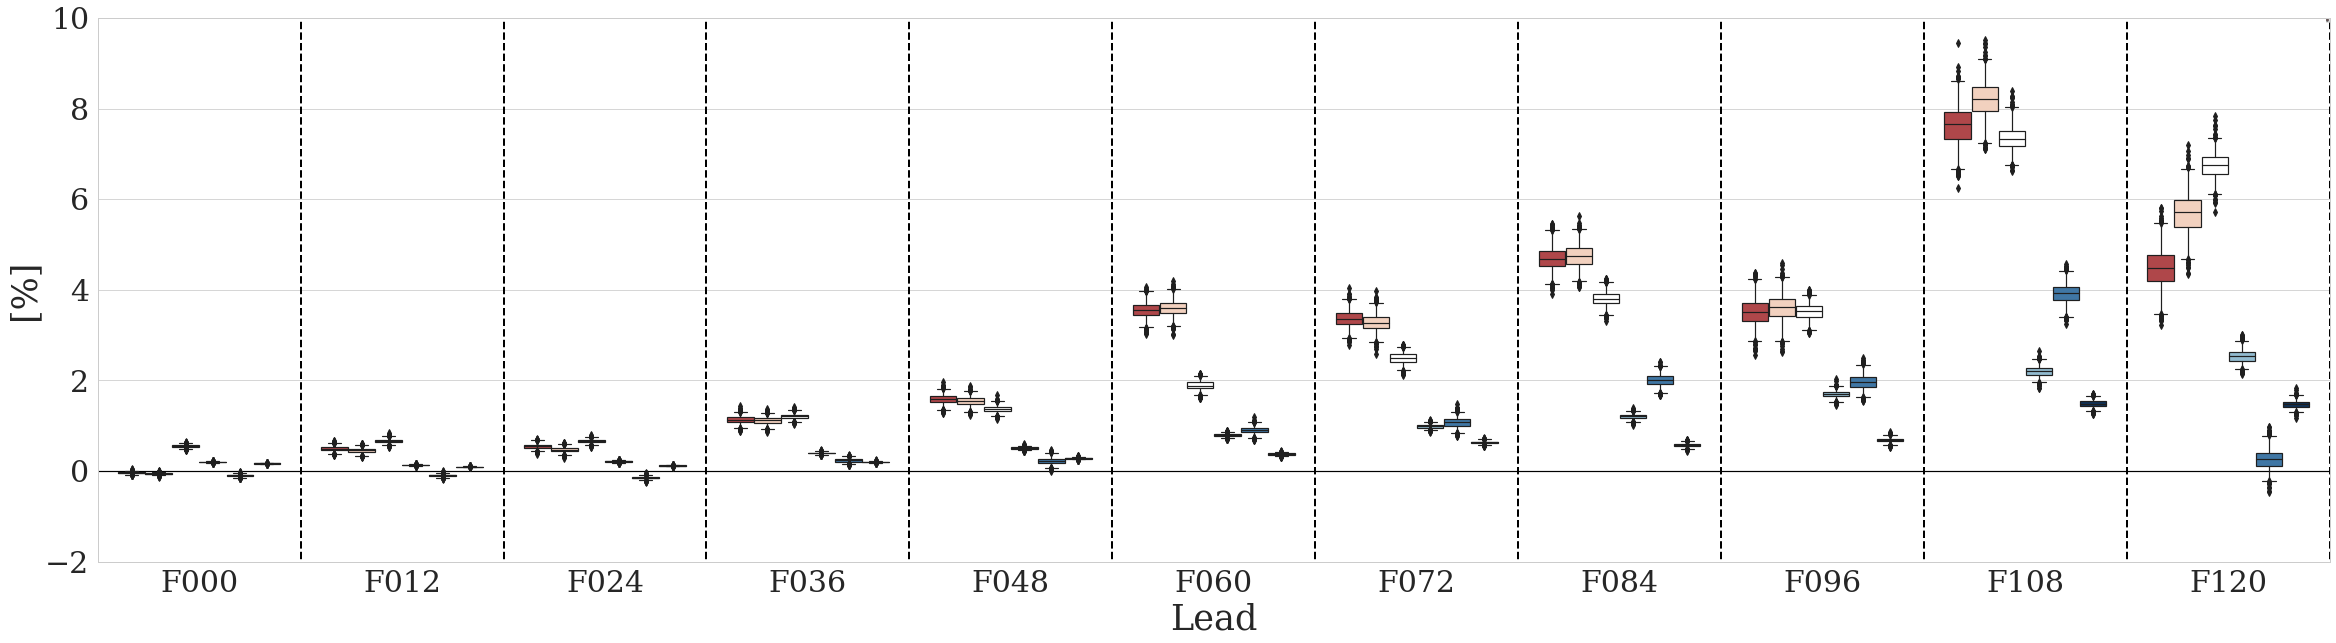

In [46]:
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context("paper")

plt.figure(figsize=BPdict['FigSize'])
plt.plot([-10,23],[0,0],'k')

ax = sns.boxplot(x="Lead", y="Corr", hue="Model",data=dffin, palette= mycolors,whis=[1,99])
plt.yticks(fontsize=BPdict['tickFS'])
plt.xticks(fontsize=BPdict['tickFS'])
plt.ylabel('[%]',fontsize=BPdict['labelFS'])
plt.xlabel('Lead',fontsize=BPdict['labelFS'])
handles, _ = ax.get_legend_handles_labels()
plt.legend(fontsize=BPdict['legendFS'])

#to turn offf....
ax.legend(handles, ["", ""],fontsize=0)

# plt.title('Correlation',fontsize=BPdict['titleFS'])

for bb in np.arange(-.5,22,1):
    plt.plot([bb,bb],[-5,20],'k--',linewidth=2)

plt.ylim([-2,10])
plt.xlim([-0.5,10.5])
plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/CORRlead_Total_FINAL.png',dpi = 300,bbox_inches='tight')
plt.show()

## Figure 4

doing: F000
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(4000, 4)
No Post-Processing
doing: F012
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(9000, 4)
No Post-Processing
doing: F024
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(14000, 4)
No Post-Processing
doing: F036
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(19000, 4)
No Post-Processing
doing: F048
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
No Post-Processing
No Po

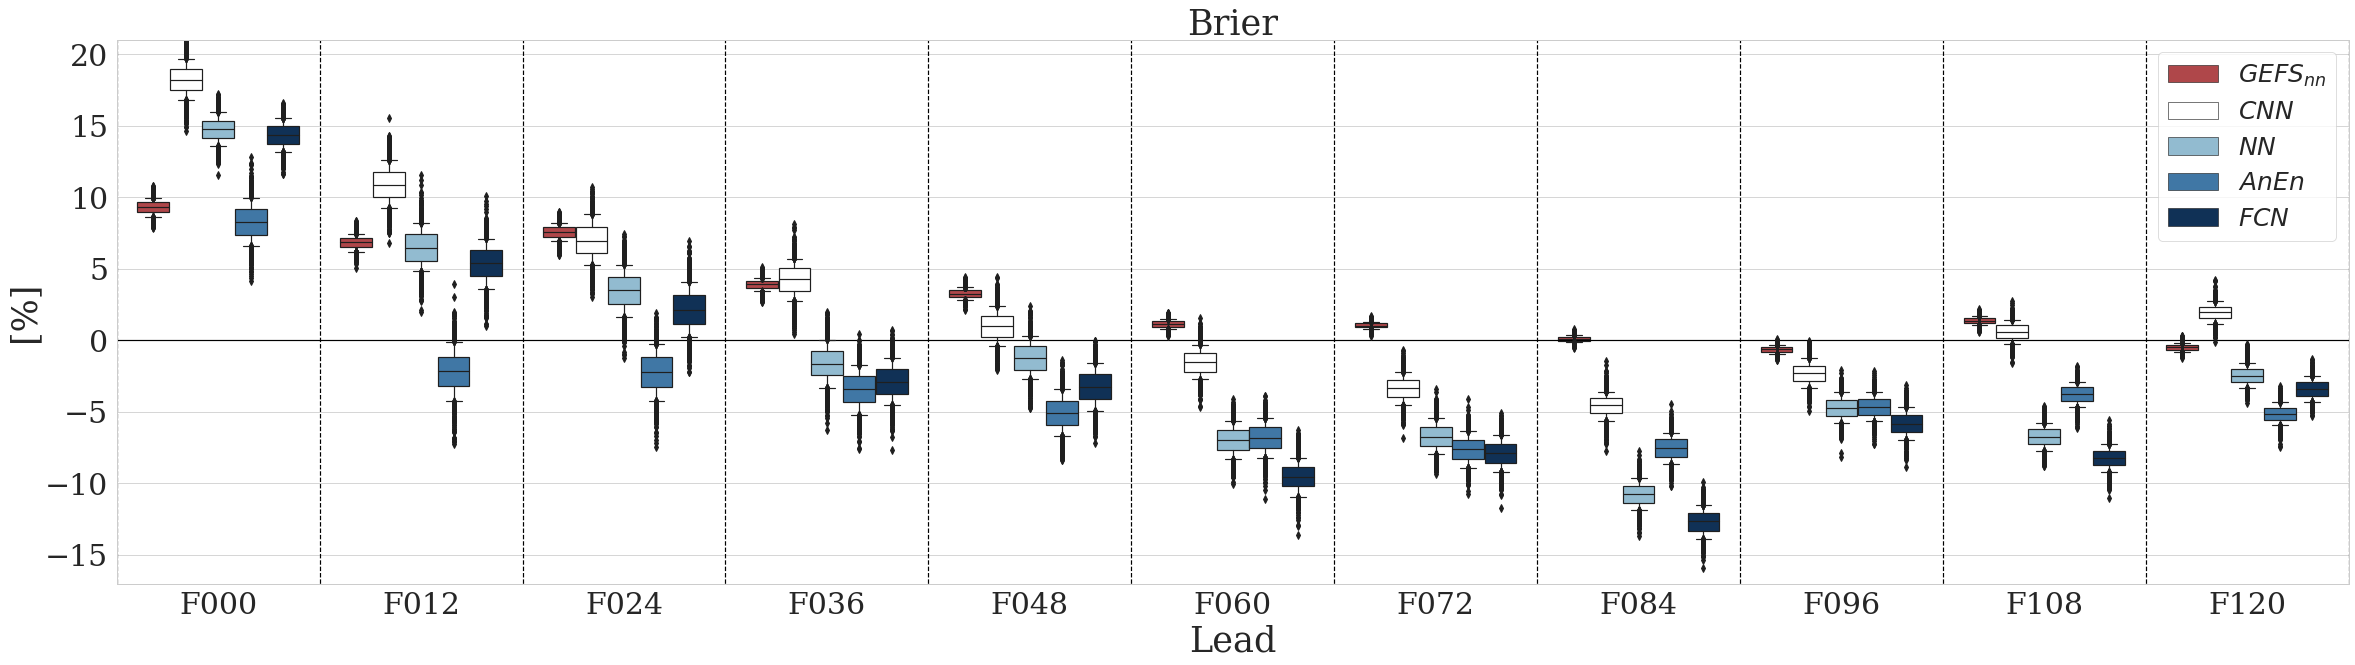

doing: F000
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(4000, 4)
No Post-Processing
doing: F012
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(9000, 4)
No Post-Processing
doing: F024
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(14000, 4)
No Post-Processing
doing: F036
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
2016
2017
2018
(19000, 4)
No Post-Processing
doing: F048
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
No Post-Processing
No Po

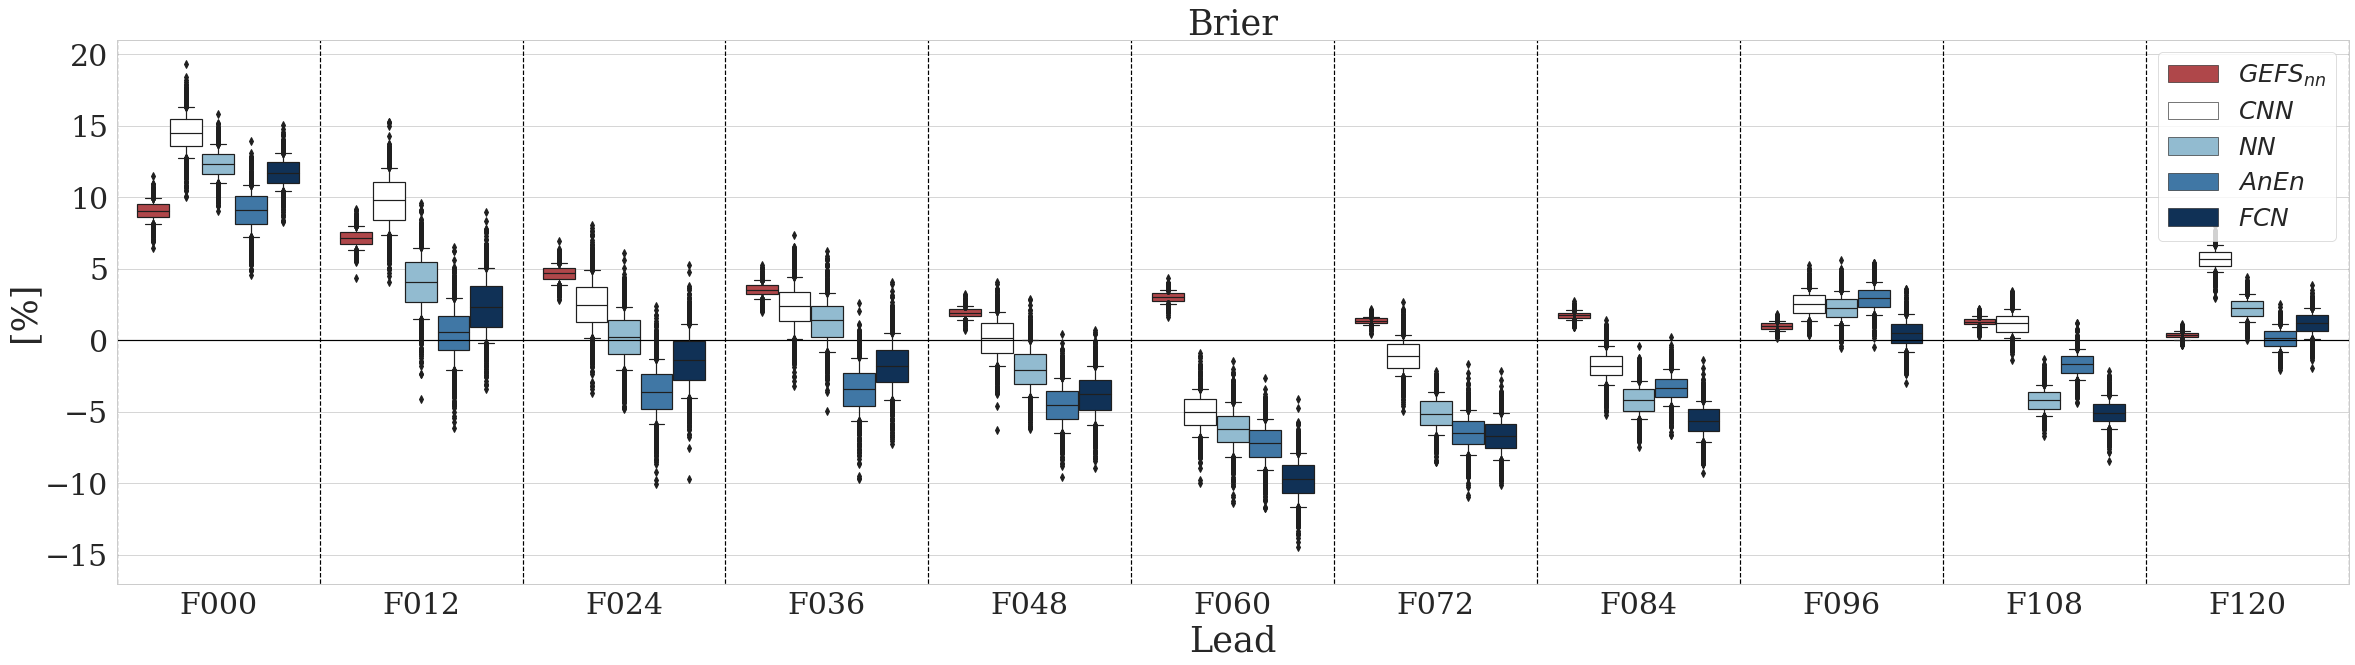

In [10]:
percys = [250,350]

bsnummy = 1000
for percy in percys:
    dffin=pd.DataFrame({'Lead':[],'Model':[],'CRPS':[]})
    fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,126,12)]
    df1, df2, dfm = 1,1,1

    for fcast in fcasts:
        print('doing:',fcast)
        ########################################################################################################
        fortts=np.array([])
        mods = ['CNNft_ref','MV_gefs','Raw_gefs','AnEn','NNft_ref']
        for mod in mods:
            df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
            fortts=np.concatenate([fortts,np.array(Post_m)])
            bounds =[]
            threshold = percy
        ##############
        print("this is the threshold:",threshold,'for a percentile:', percy)
        ########################################################################################################
        del df1
        del df2
        del dfm
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'NN_gefs'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})

        dfm = pd.merge(df1,df2,how='left')

        bp_nn = np.zeros([bsnummy])
        cor_nn= np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
        
            ff = np.stack([dfm['IVTmean_cnn'][inss],dfm['IVTstd_cnn'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBScnn'][inss])>=threshold)*1

            bp_nn[aa] = (1 - (brier_score_loss(verif_for, probs_for)/brier_score_loss(verif_forg, probs_forg)))*100
    
        dftemp = pd.DataFrame({'Brier':bp_nn})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$GEFS_{nn}$'
        dffin = pd.concat([dffin, dftemp], axis=0)
    
        ########################################################################################################
        del df1
        del df2
        del dfm
    
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'CNN_ref'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
        df2['lon']=df2['lon']+360

        dfm = pd.merge(df1,df2,how='left')

        bp_cnn = np.zeros([bsnummy])
        cor_cnn= np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
        
            ff = np.stack([dfm['IVTmean_cnn'][inss],dfm['IVTstd_cnn'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBScnn'][inss])>=threshold)*1

            bp_cnn[aa] = (1 - (brier_score_loss(verif_for, probs_for)/brier_score_loss(verif_forg, probs_forg)))*100
    
        dftemp = pd.DataFrame({'Brier':bp_cnn})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$CNN$'
        dffin = pd.concat([dffin, dftemp], axis=0)
        
        ########################################################################################################
        del df1
        del df2
        del dfm
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'NNft_ref'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
        df2['lon']=df2['lon']+360

        dfm = pd.merge(df1,df2,how='left')

        bp_nn = np.zeros([bsnummy])
        cor_nn = np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
            
            ff = np.stack([dfm['IVTmean_nn'][inss],dfm['IVTstd_nn'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBSnn'][inss])>=threshold)*1

            bp_nn[aa] = (1 - (brier_score_loss(verif_for, probs_for)/brier_score_loss(verif_forg, probs_forg)))*100

        dftemp = pd.DataFrame({'Brier':bp_nn})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$NN$'
        dffin = pd.concat([dffin, dftemp], axis=0)
    
    
    
        ########################################################################################################
        del df1
        del df2
        del dfm
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'AnEn'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBSanen','Model':'Reforecast','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
        df2['Mean'] = np.mean(df2.filter(regex='Analog'),axis=1)
        df2['std'] = np.std(df2.filter(regex='Analog'),axis=1)
        df2['time']= df2['Issued_Time']+ timedelta(hours=int(fcast[-3:]))

        dfm = pd.merge(df1,df2,how='left')
    
        bp_anen = np.zeros([bsnummy])
        corr_anen = np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
        
            ff = np.stack([dfm['Mean'][inss],dfm['std'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBSanen'][inss])>=threshold)*1

            bp_anen[aa] = (1 - (brier_score_loss(verif_for, probs_for)/brier_score_loss(verif_forg, probs_forg)))*100
    
        dftemp = pd.DataFrame({'Brier':bp_anen})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$AnEn$'
        dffin = pd.concat([dffin, dftemp], axis=0)
    
        print(dffin.shape)
        
        ########################################################################################################
        del df1
        del df2
        del dfm
        
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnn','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})

        mod = 'EMOS'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBSemos','Model':'Reforecast','IVTmean':'IVTmean_emos','IVTstd':'IVTstd_emos'})
        df2['lon']=df2['lon']+360
        
        
        dfm = pd.merge(df1,df2,how='left')

        bp_nn = np.zeros([bsnummy])
        cor_nn = np.zeros([bsnummy])
        for aa in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])        
            ff = np.stack([dfm['IVTmean_gefs'][inss],dfm['IVTstd_gefs'][inss]]).T
            probs_forg = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_forg = (np.array(dfm['OBSnn'][inss])>=threshold)*1
            
            ff = np.stack([dfm['IVTmean_emos'][inss],dfm['IVTstd_emos'][inss]]).T
            probs_for = utils_verif.prob_ob(threshold,ff[:,0],ff[:,1])
            verif_for = (np.array(dfm['OBSnn'][inss])>=threshold)*1

            bp_nn[aa] = (1 - (brier_score_loss(verif_for, probs_for)/brier_score_loss(verif_forg, probs_forg)))*100

        dftemp = pd.DataFrame({'Brier':bp_nn})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$FCN$'
        dffin = pd.concat([dffin, dftemp], axis=0)
   
    
    
    plt.figure(figsize=BPdict['FigSize'])
    plt.plot([-10,23],[0,0],'k')

    ax = sns.boxplot(x="Lead", y="Brier", hue="Model",data=dffin, palette=mycolors,whis=[10, 90])
    plt.yticks(fontsize=BPdict['tickFS'])
    plt.xticks(fontsize=BPdict['tickFS'])
    plt.ylabel('[%]',fontsize=BPdict['labelFS'])
    plt.xlabel('Lead',fontsize=BPdict['labelFS'])
    plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
    plt.title('Brier',fontsize=BPdict['titleFS'])

    for bb in np.arange(-0.5,22,1):
        plt.plot([bb,bb],[-25,25],'k--')

    plt.ylim([-17,21])
    plt.xlim([-0.5,10.5])

    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Brier_FINAL_threshold_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')


    plt.show()



## TW CRPS

In [11]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def f_emp(ens,x):
    xs,ys = ecdf(ens)
    vals=[]
    vals = np.zeros([len(x)])
    for bb,xT in enumerate(x):
        if all(xs>xT):
            vals[bb] = 0
        elif (np.sum(1*(xs>xT))>0) & (np.sum(1*(xs>xT))<len(xs)):
            inds = np.searchsorted(xs>xT, 0.5)
            vals[bb] =ys[inds-1]
        else:
            vals[bb] = 1
    return np.array(vals)

def f_emp2(ens,x):
    xs,ys = ecdf(ens)
    dogs = np.searchsorted(xs,x,side='right')
    vals =ys[dogs-1]
    vals[dogs==0]=0
    return np.array(vals)

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
#     print((f_emp(ens,eval_z).shape))
    out = np.sum(w(eval_z)*((f_emp(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample2(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
    
#     print(eval_z.shape)
#     print((f_emp2(ens,eval_z).shape))
    
    out = np.sum(w(eval_z)*((f_emp2(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out


## TW Crps

In [12]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def f_emp(ens,x):
    xs,ys = ecdf(ens)
    vals=[]
    vals = np.zeros([len(x)])
    for bb,xT in enumerate(x):
        if all(xs>xT):
            vals[bb] = 0
        elif (np.sum(1*(xs>xT))>0) & (np.sum(1*(xs>xT))<len(xs)):
            inds = np.searchsorted(xs>xT, 0.5)
            vals[bb] =ys[inds-1]
        else:
            vals[bb] = 1
    return np.array(vals)

def f_emp2(ens,x):
    xs,ys = ecdf(ens)
    dogs = np.searchsorted(xs,x,side='right')
    vals =ys[dogs-1]
    vals[dogs==0]=0
    return np.array(vals)

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
#     print((f_emp(ens,eval_z).shape))
    out = np.sum(w(eval_z)*((f_emp(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample2(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
    
#     print(eval_z.shape)
#     print((f_emp2(ens,eval_z).shape))
    
    out = np.sum(w(eval_z)*((f_emp2(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out


## Figure 5

doing: F000
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F012
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F024
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F036
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F048
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F060
No Post-Processing
2016
2017
2018
this is the threshold: 250 for a percentile: 250
No Post-Processing
2016
2017
2018
calc t

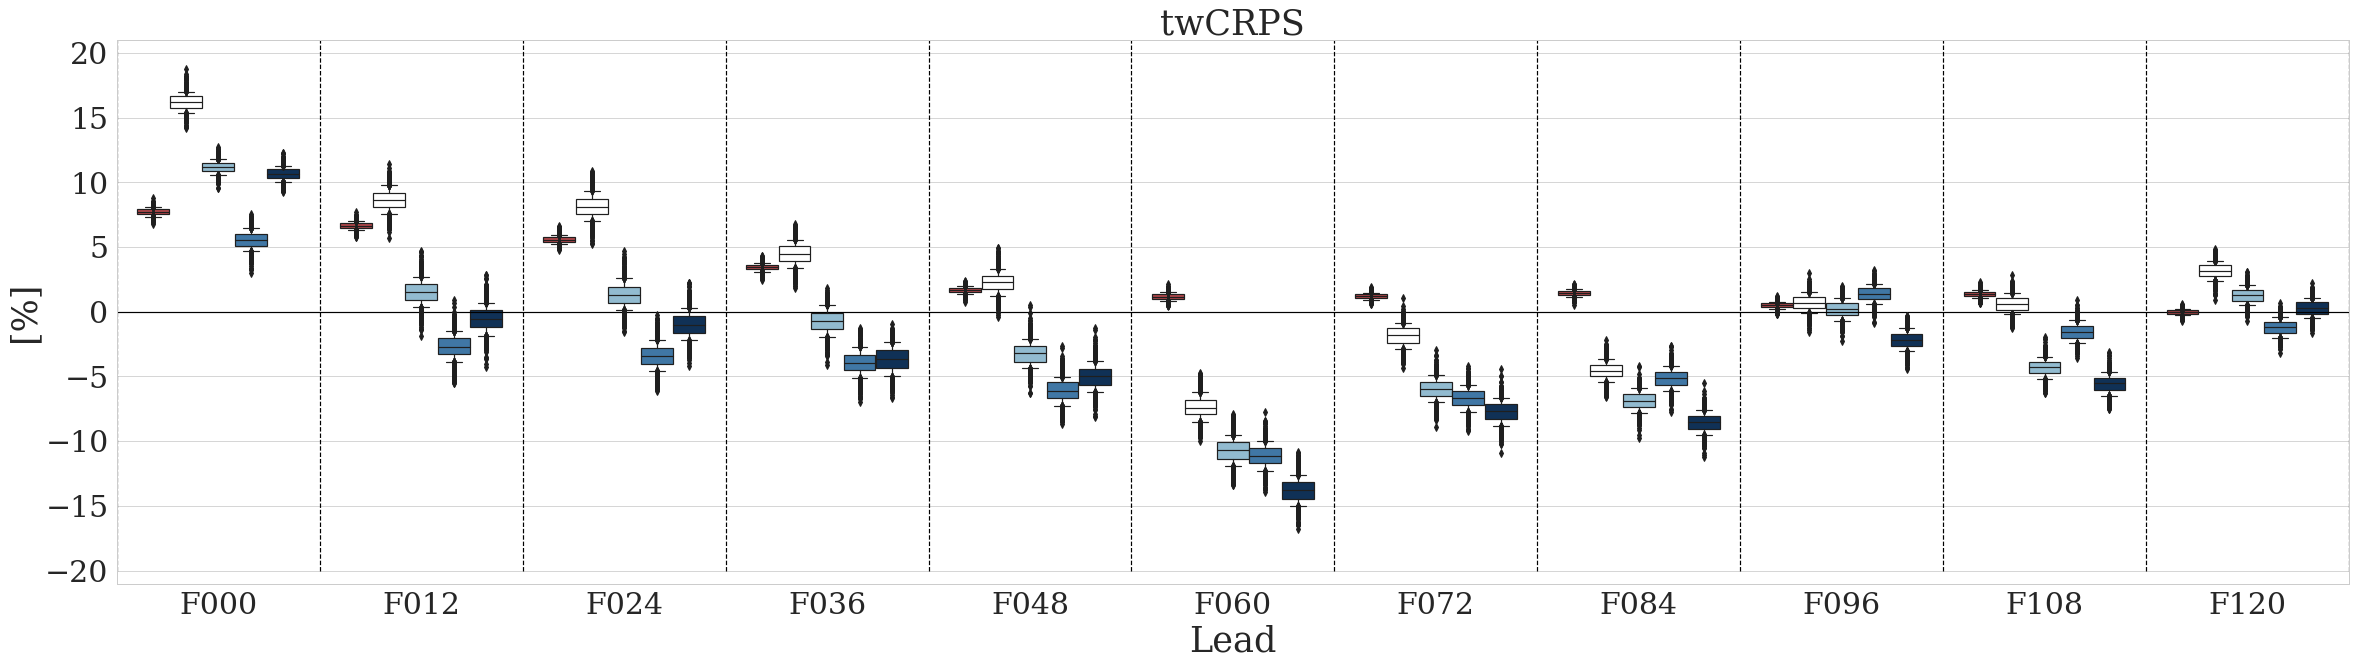

doing: F000
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F012
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F024
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F036
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F048
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F060
No Post-Processing
2016
2017
2018
this is the threshold: 350 for a percentile: 350
No Post-Processing
2016
2017
2018
calc t

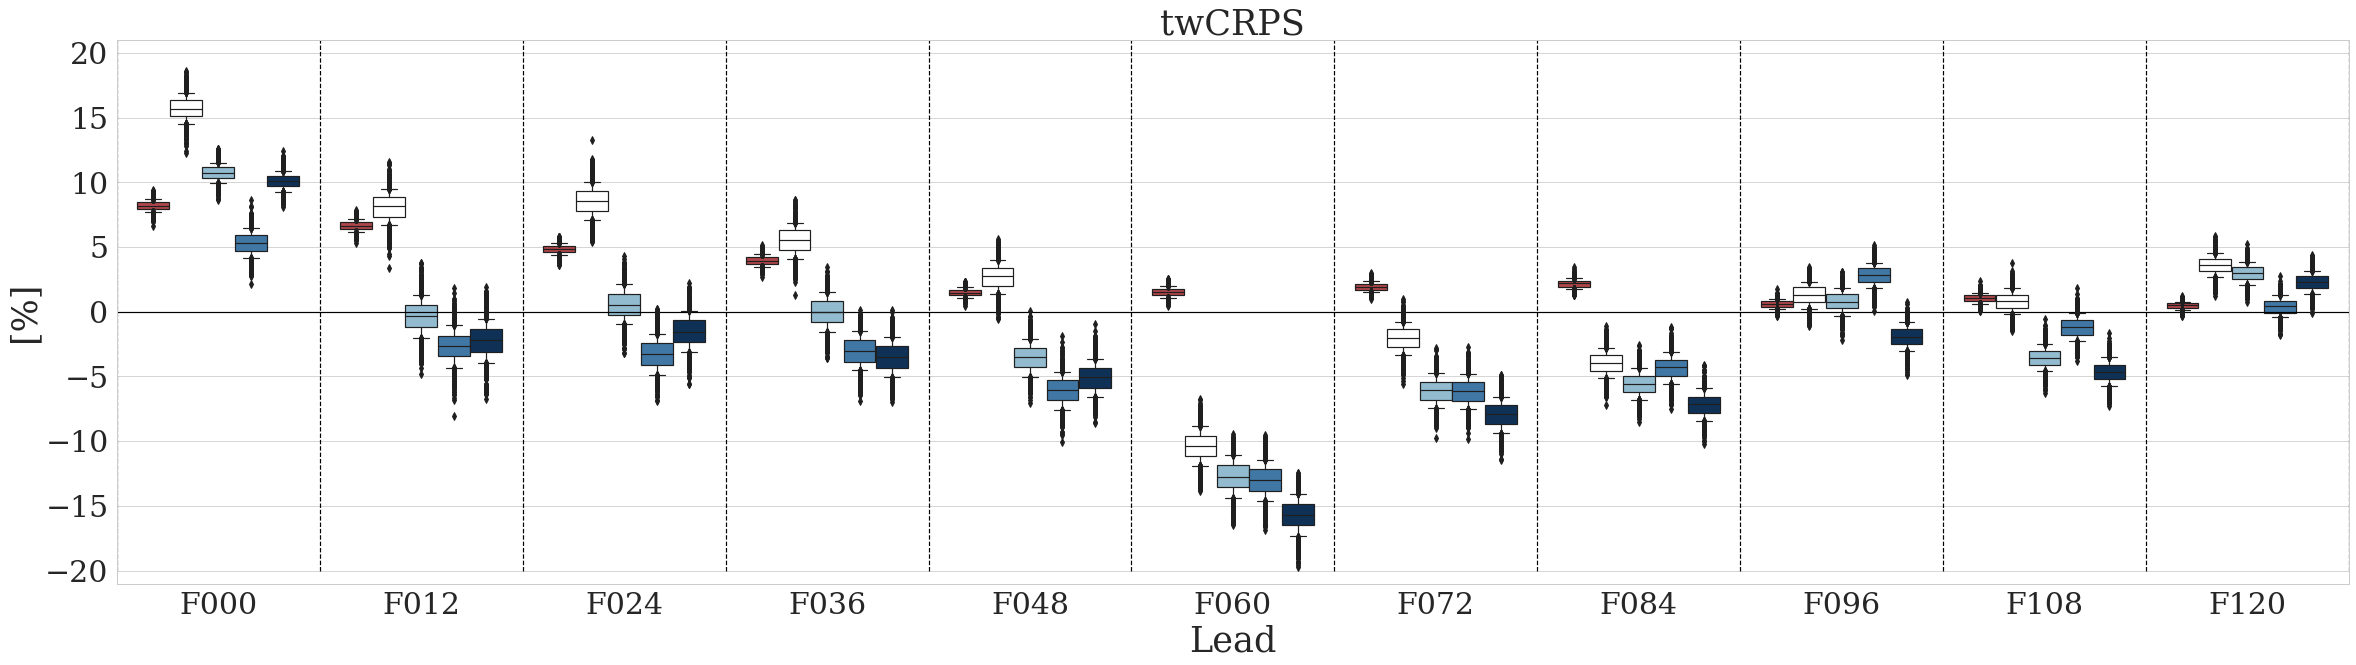

doing: F000
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F012
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F024
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F036
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F048
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
calc tw-crps
...boostrapping....
...done...
doing: F060
No Post-Processing
2016
2017
2018
this is the threshold: 500 for a percentile: 500
No Post-Processing
2016
2017
2018
calc t

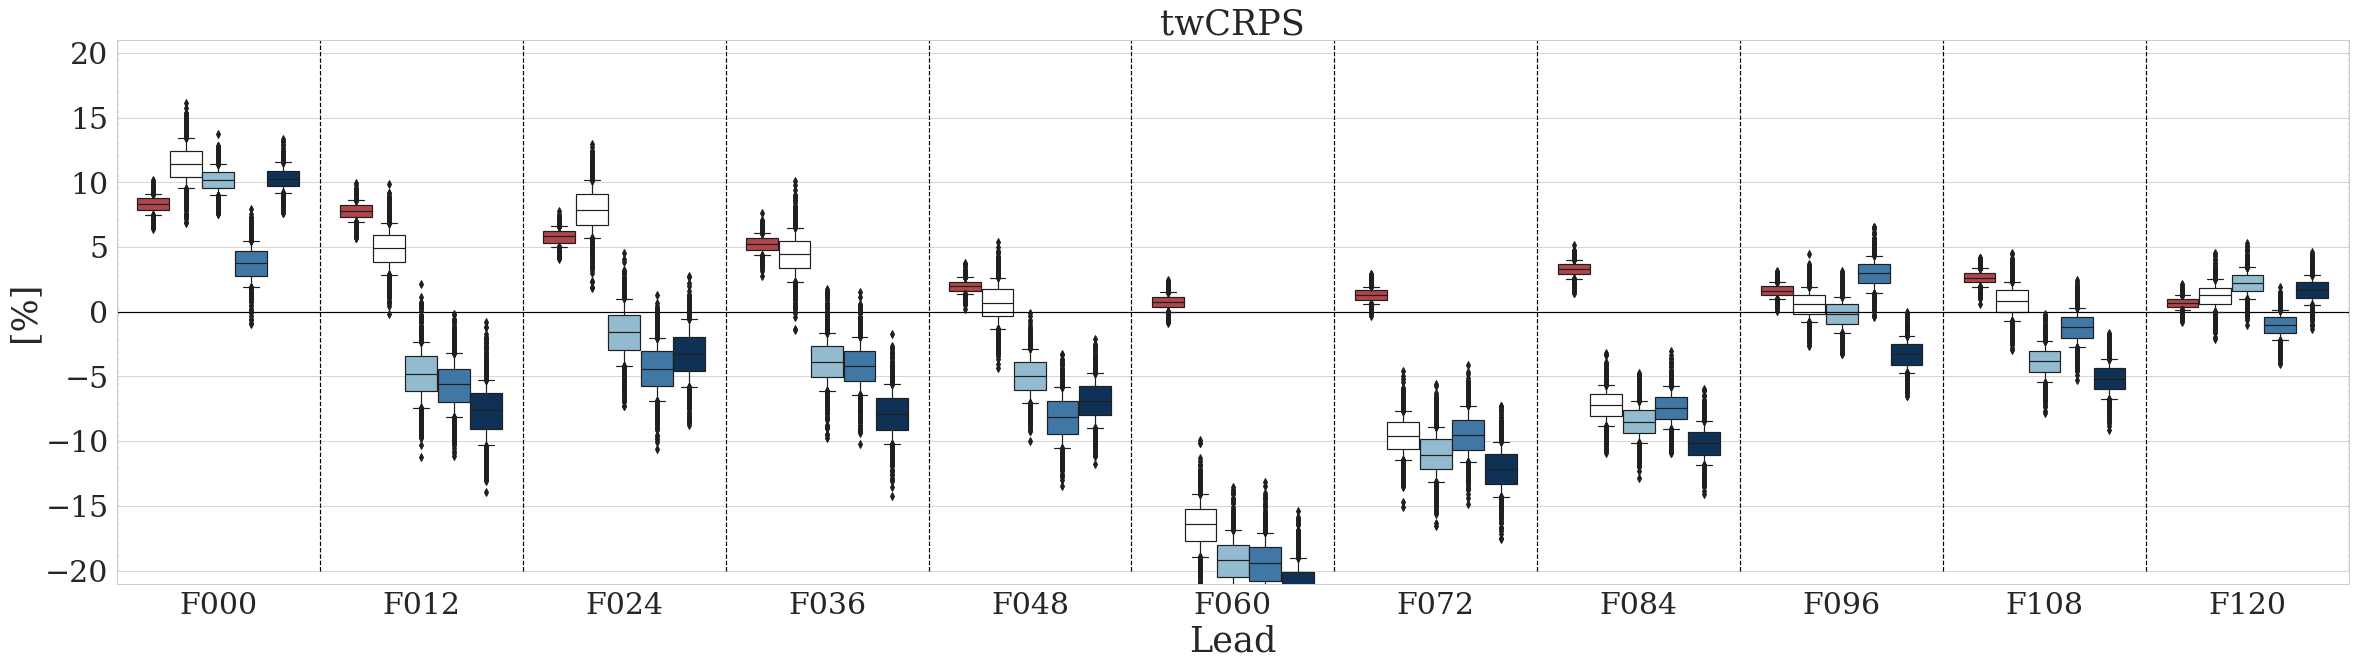

In [13]:
percys = [250,350,500]

bsnummy = 1000
for percy in percys:
    
    dffin=pd.DataFrame({'Lead':[],'Model':[],'CRPS':[]})
    fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,126,12)]
    ense = 100

    for fcast in fcasts:
        print('doing:',fcast)
        fortts=np.array([])
        mods = ['CNNft_ref','MV_gefs','Raw_gefs','AnEn','NN_ref']
        for mod in mods:
            df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
            fortts=np.concatenate([fortts,np.array(Post_m)])
            bounds =[]
#             threshold = np.percentile(fortts,percy)
            threshold=percy
        ##############
        print("this is the threshold:",threshold,'for a percentile:', percy)
        ########################################################################################################
        mod = 'Raw_gefs'
        df1,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df1 = df1.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_gefs','IVTstd':'IVTstd_gefs'})
    
        mod = 'CNNft_ref'
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df2 = df2.rename(columns={'OBS':'OBScnn','Model':'Reforecast_cnn','IVTmean':'IVTmean_cnn','IVTstd':'IVTstd_cnn'})
        df2['lon']=df2['lon']+360
    
        mod = 'NNft_ref'
        df3,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df3 = df3.rename(columns={'OBS':'OBSnn','Model':'Reforecast_nn','IVTmean':'IVTmean_nn','IVTstd':'IVTstd_nn'})
        df3['lon']=df3['lon']+360
    
    
        mod = 'AnEn'
        df4,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df4 = df4.rename(columns={'OBS':'OBSanen','Model':'Reforecast_AnEn','IVTmean':'IVTmean_anen','IVTstd':'IVTstd_anen'})
        df4['AnEn_Mean'] = np.mean(df4.filter(regex='Analog'),axis=1)
        df4['AnEn_std'] = np.std(df4.filter(regex='Analog'),axis=1)
        df4['time']= df4['Issued_Time']+ timedelta(hours=int(fcast[-3:]))
    
        mod = 'NN_gefs'
        df5,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df5 = df5.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_nngefs','IVTstd':'IVTstd_nngefs'})
        
        mod = 'MV_gefs'
        df6,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df6 = df6.rename(columns={'OBS':'OBSnng','Model':'Reforecast','IVTmean':'IVTmean_mvgefs','IVTstd':'IVTstd_mvgefs'})
        
        mod = 'EMOS'
        df7,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df7 = df7.rename(columns={'OBS':'OBSemos','Model':'Reforecast','IVTmean':'IVTmean_emos','IVTstd':'IVTstd_emos'})
        df7['lon']=df7['lon']+360

        dfm = pd.merge(df1,df2,how='left')
        dfm = pd.merge(dfm,df3,how='left')
        dfm = pd.merge(dfm,df4,how='left')
        dfm = pd.merge(dfm,df5,how='left')
        dfm = pd.merge(dfm,df6,how='left')
        dfm = pd.merge(dfm,df7,how='left')
    
    
        #define 4 groups:
        Merrag = dfm['OBSnng']
        For_ug = dfm['IVTmean_gefs']
        For_sg = dfm['IVTstd_gefs']
    
        Merranng = dfm['OBSnng']
        For_unng = dfm['IVTmean_nngefs']
        For_snng = dfm['IVTstd_nngefs']
    
        Merrac = dfm['OBScnn']
        For_uc = dfm['IVTmean_cnn']
        For_sc = dfm['IVTstd_cnn']
    
        Merran = dfm['OBSnn']
        For_un = dfm['IVTmean_nn']
        For_sn = dfm['IVTstd_nn']
    
        Merraa = dfm['OBSanen']
        For_ua = dfm['AnEn_Mean']
        For_sa = dfm['AnEn_std']
        
        Merramvg = dfm['OBSnng']
        For_umvg = dfm['IVTmean_mvgefs']
        For_smvg = dfm['IVTstd_mvgefs']

        Merraemos = dfm['OBSemos']
        For_uemos = dfm['IVTmean_emos']
        For_semos = dfm['IVTstd_emos']
        
        #aadefine 4 groups:
        Ensemblg = np.zeros([Merrag.shape[0],ense])
        Truthg = np.zeros([Merrag.shape[0]])
        Ensemblc = np.zeros([Merrag.shape[0],ense])
        Truthc = np.zeros([Merrag.shape[0]])
        Ensembln = np.zeros([Merran.shape[0],ense])
        Truthn = np.zeros([Merran.shape[0]])    
        Ensembla = np.zeros([Merraa.shape[0],ense])
        Trutha = np.zeros([Merraa.shape[0]])
        Ensemblnng = np.zeros([Merrag.shape[0],ense])
        Truthnng = np.zeros([Merrag.shape[0]])
        Ensemblmvg = np.zeros([Merrag.shape[0],ense])
        Truthmvg = np.zeros([Merrag.shape[0]])
        Ensemblemos = np.zeros([Merrag.shape[0],ense])
        Truthemos = np.zeros([Merrag.shape[0]])
        
        
        for gre in range(Merrag.shape[0]):
            Ensemblg[gre,:]=np.random.normal(For_ug[gre],For_sg[gre],100)
            Truthg[gre] = Merrag[gre]
            Ensemblc[gre,:]=np.random.normal(For_uc[gre],For_sc[gre],100)
            Truthc[gre] = Merrac[gre]
            Ensembln[gre,:]=np.random.normal(For_un[gre],For_sn[gre],100)
            Truthn[gre] = Merran[gre]
            Ensembla[gre,:]=np.random.normal(For_ua[gre],For_sa[gre],100)
            Trutha[gre] = Merraa[gre]
            Ensemblnng[gre,:]=np.random.normal(For_unng[gre],For_snng[gre],100)
            Truthnng[gre] = Merranng[gre]
            Ensemblmvg[gre,:]=np.random.normal(For_umvg[gre],For_smvg[gre],100)
            Truthmvg[gre] = Merramvg[gre]
            Ensemblemos[gre,:]=np.random.normal(For_uemos[gre],For_semos[gre],100)
            Truthemos[gre] = Merraemos[gre]

    
        CRPStempg = np.zeros((Merrag.shape[0]))
        CRPStempnng = np.zeros((Merranng.shape[0]))
        CRPStempmvg = np.zeros((Merramvg.shape[0]))
        CRPStempc = np.zeros((Merrac.shape[0]))
        CRPStempn = np.zeros((Merran.shape[0]))
        CRPStempa = np.zeros((Merraa.shape[0]))
        CRPStempemos = np.zeros((Merraemos.shape[0]))
    
        print('calc tw-crps')

    
        for gre in range(0,Merrac.shape[0]):    
            if np.max(np.append(Merrac[gre],Ensemblc[gre,:]))<=threshold:
                CRPStempc[gre] = 0
            else:
                CRPStempc[gre] = twcrps_sample2(Merrac[gre],Ensemblc[gre,:],'indicator.right',threshold,step_width=10)


        for gre in range(0,Merrag.shape[0]):    
            if np.max(np.append(Merrag[gre],Ensemblg[gre,:]))<=threshold:
                CRPStempg[gre] = 0
            else:
                CRPStempg[gre] = twcrps_sample2(Merrag[gre],Ensemblg[gre,:],'indicator.right',threshold,step_width=10)

     
        for gre in range(0,Merran.shape[0]):    
            if np.max(np.append(Merran[gre],Ensembln[gre,:]))<=threshold:
                CRPStempn[gre] = 0
            else:
                CRPStempn[gre] = twcrps_sample2(Merran[gre],Ensembln[gre,:],'indicator.right',threshold,step_width=10)


        for gre in range(0,Merraa.shape[0]):    
            if np.max(np.append(Merraa[gre],Ensembla[gre,:]))<=threshold:
                CRPStempa[gre] = 0
            else:
                CRPStempa[gre] = twcrps_sample2(Merraa[gre],Ensembla[gre,:],'indicator.right',threshold,step_width=10)
            
        for gre in range(0,Merraa.shape[0]):    
            if np.max(np.append(Merranng[gre],Ensemblnng[gre,:]))<=threshold:
                CRPStempnng[gre] = 0
            else:
                CRPStempnng[gre] = twcrps_sample2(Merranng[gre],Ensemblnng[gre,:],'indicator.right',threshold,step_width=10)
                                
                
        for gre in range(0,Merraa.shape[0]):    
            if np.max(np.append(Merraemos[gre],Ensemblemos[gre,:]))<=threshold:
                CRPStempemos[gre] = 0
            else:
                CRPStempemos[gre] = twcrps_sample2(Merraemos[gre],Ensemblemos[gre,:],'indicator.right',threshold,step_width=10)
                                
    
    
        print("...boostrapping....")
#     bootstrap randomdraws:
        CRPScnn_ref = np.zeros(bsnummy)
        CRPSnn_ref = np.zeros(bsnummy)
        CRPSanen_ref = np.zeros(bsnummy)
        CRPSnng_gefs = np.zeros(bsnummy)
        CRPSemos_ref = np.zeros(bsnummy)
        
                                
                                
    
        for bb in range(bsnummy):
            inss = np.random.randint(dfm.shape[0], size=dfm.shape[0])
            CRPScnn_ref[bb] = (1 - (np.mean(CRPStempc[inss])/np.mean(CRPStempg[inss])))*100
            CRPSnn_ref[bb] = (1 - (np.mean(CRPStempn[inss])/np.mean(CRPStempg[inss])))*100
            CRPSanen_ref[bb] = (1 - (np.mean(CRPStempa[inss])/np.mean(CRPStempg[inss])))*100
            CRPSnng_gefs[bb] = (1 - (np.mean(CRPStempnng[inss])/np.mean(CRPStempg[inss])))*100
            CRPSemos_ref[bb] = (1 - (np.mean(CRPStempemos[inss])/np.mean(CRPStempg[inss])))*100
        
        #define 3 groups:  
        dftemp = pd.DataFrame({'CRPS':CRPSnng_gefs})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$GEFS_{nn}$'
        dffin = pd.concat([dffin, dftemp], axis=0)
        
        dftemp = pd.DataFrame({'CRPS':CRPScnn_ref})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$CNN$'
        dffin = pd.concat([dffin, dftemp], axis=0)
    
        dftemp = pd.DataFrame({'CRPS':CRPSnn_ref})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$NN$'
        dffin = pd.concat([dffin, dftemp], axis=0)
    
        dftemp = pd.DataFrame({'CRPS':CRPSanen_ref})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$AnEn$'
        dffin = pd.concat([dffin, dftemp], axis=0)
        
        dftemp = pd.DataFrame({'CRPS':CRPSemos_ref})
        dftemp['Lead'] = fcast
        dftemp['Model'] = '$FCN$'
        dffin = pd.concat([dffin, dftemp], axis=0)
        
        print('...done...')
    
    
    plt.figure(figsize=BPdict['FigSize'])
    plt.plot([-10,23],[0,0],'k')

    ax = sns.boxplot(x="Lead", y="CRPS", hue="Model",data=dffin, palette=mycolors,whis=[10, 90])
    plt.yticks(fontsize=BPdict['tickFS'])
    plt.xticks(fontsize=BPdict['tickFS'])
    plt.ylabel('[%]',fontsize=BPdict['labelFS'])
    plt.xlabel('Lead',fontsize=BPdict['labelFS'])
#     plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
    ax.get_legend().remove()
    plt.title('twCRPS',fontsize=BPdict['titleFS'])

    for bb in np.arange(-0.5,22,1):
        plt.plot([bb,bb],[-20,25],'k--')

    plt.ylim([-21,21])
    plt.xlim([-0.5,10.5])
    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_threshold_FINAL_no_legend_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')

    plt.show()

## Figure 6

In [113]:
numbins = 15
fcasts = ['F'+f'{bb:03}' for bb in np.arange(54,126,6)]

Post_m_c = np.array([])
Obs_c = np.array([])
Post_s_c = np.array([])

Post_m1_c = np.array([])
Obs1_c = np.array([])
Post_s1_c = np.array([])

Post_m2_c = np.array([])
Obs2_c = np.array([])
Post_s2_c = np.array([])

Post_m3_c = np.array([])
Obs3_c = np.array([])
Post_s3_c = np.array([])

Post_m4_c = np.array([])
Obs4_c = np.array([])
Post_s4_c = np.array([])

Post_m5_c = np.array([])
Obs5_c = np.array([])
Post_s5_c = np.array([])


for fcast in fcasts:
    print('doing:', fcast)
    ##
    mod = 'NN_gefs'
    df,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    
    Post_m_c = np.concatenate([Post_m_c,Post_m])
    Obs_c = np.concatenate([Obs_c,Obs])
    Post_s_c = np.concatenate([Post_s_c,Post_s])

    ##
    mod = 'CNNft_ref'
    df1,Pre_m1, Pre_s1, Post_m1, Post_s1, Obs1 = utils_verif.load_forecast(fcast,mod)
    
    Post_m1_c = np.concatenate([Post_m1_c,Post_m1])
    Obs1_c = np.concatenate([Obs1_c,Obs1])
    Post_s1_c = np.concatenate([Post_s1_c,Post_s1])

    ##
    mod = 'NNft_ref'
    df2,Pre_m2, Pre_s2, Post_m2, Post_s2, Obs2 = utils_verif.load_forecast(fcast,mod)
    
    Post_m2_c = np.concatenate([Post_m2_c,Post_m2])
    Obs2_c = np.concatenate([Obs2_c,Obs2])
    Post_s2_c = np.concatenate([Post_s2_c,Post_s2])

    ##
    mod = 'AnEn'
    df3,Pre_m3, Pre_s3, Post_m3, Post_s3, Obs3 = utils_verif.load_forecast(fcast,mod)
    
    Post_m3_c = np.concatenate([Post_m3_c,Post_m3])
    Obs3_c = np.concatenate([Obs3_c,Obs3])
    Post_s3_c = np.concatenate([Post_s3_c,Post_s3])

    ##
    mod = 'Raw_gefs'
    df4,Pre_m4, Pre_s4, Post_m4, Post_s4, Obs4 = utils_verif.load_forecast(fcast,mod)
    
    Post_m4_c = np.concatenate([Post_m4_c,Post_m4])
    Obs4_c = np.concatenate([Obs4_c,Obs4])
    Post_s4_c = np.concatenate([Post_s4_c,Post_s4])
    
    ##
    mod = 'EMOS'
    df5,Pre_m5, Pre_s5, Post_m5, Post_s5, Obs5 = utils_verif.load_forecast(fcast,mod)
    
    Post_m5_c = np.concatenate([Post_m5_c,Post_m5])
    Obs5_c = np.concatenate([Obs5_c,Obs5])
    Post_s5_c = np.concatenate([Post_s5_c,Post_s5])
    
    
    

    
    
print('####################')
print('..doing spread/skill...')
print('####################')

[avgvar_m,msebin_m,avgvar_s,msebin_s] = utils_verif.spreadskill(Post_m_c,Obs_c,Post_s_c,numbins)
print('1')
[avgvar_m1,msebin_m1,avgvar_s1,msebin_s1] = utils_verif.spreadskill(Post_m1_c,Obs1_c,Post_s1_c,numbins)
print('2')
[avgvar_m2,msebin_m2,avgvar_s2,msebin_s2] = utils_verif.spreadskill(Post_m2_c,Obs2_c,Post_s2_c,numbins)
print('3')
[avgvar_m3,msebin_m3,avgvar_s3,msebin_s3] = utils_verif.spreadskill(Post_m3_c,Obs3_c,Post_s3_c,numbins)
print('4')
[avgvar_m4,msebin_m4,avgvar_s4,msebin_s4] = utils_verif.spreadskill(Post_m4_c,Obs4_c,Post_s4_c,numbins)
print('5')
[avgvar_m5,msebin_m5,avgvar_s5,msebin_s5] = utils_verif.spreadskill(Post_m5_c,Obs5_c,Post_s5_c,numbins)
print('....done.....')


doing: F054
2016
2017
2018
No Post-Processing
doing: F060
2016
2017
2018
No Post-Processing
doing: F066
2016
2017
2018
No Post-Processing
doing: F072
2016
2017
2018
No Post-Processing
doing: F078
2016
2017
2018
No Post-Processing
doing: F084
2016
2017
2018
No Post-Processing
doing: F090
2016
2017
2018
No Post-Processing
doing: F096
2016
2017
2018
No Post-Processing
doing: F102
2016
2017
2018
No Post-Processing
doing: F108
2016
2017
2018
No Post-Processing
doing: F114
2016
2017
2018
No Post-Processing
doing: F120
2016
2017
2018
No Post-Processing
####################
..doing spread/skill...
####################
1
2
3
4
5
....done.....


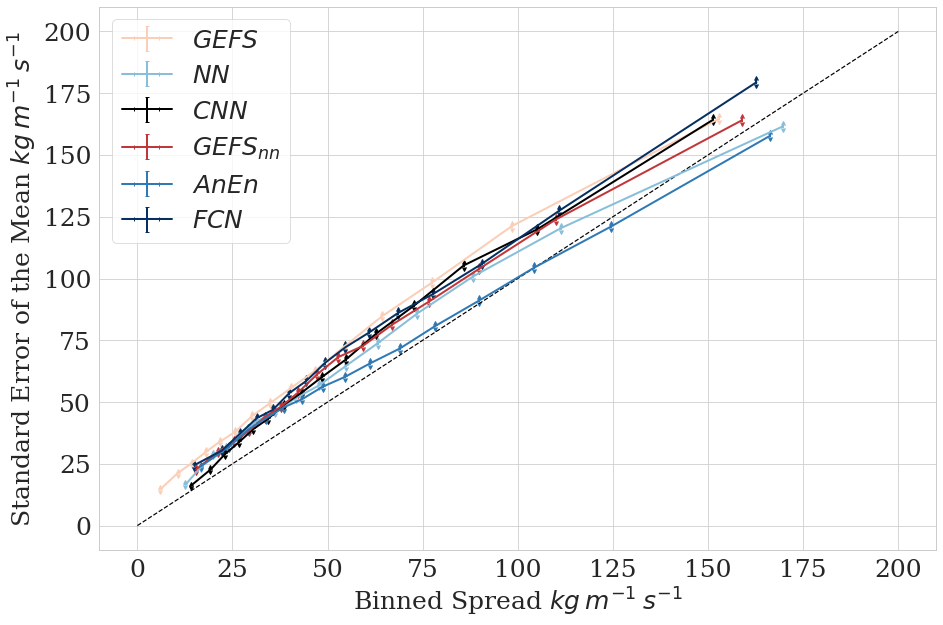

In [114]:
mycolors = {'$GEFS_{nn}$':[0.7561707035755478, 0.21038062283737025, 0.22352941176470587], 
            '$MV_gefs$':[0.940715109573241, 0.6099192618223759, 0.4812764321414839],
            '$GEFS$':[0.9838523644752019, 0.8089965397923875, 0.7167243367935409],
            '$CNN$':[1,1,1],
            '$CNNft_ref$': [1,1,1],
            '$NN$': [0.530026912725875, 0.7456362937331797, 0.8560553633217994],
            '$AnEn$': [0.1843137254901961, 0.47266435986159167, 0.7116493656286044],
            '$FCN$': [0.0196078431372549, 0.18823529411764706, 0.3803921568627451]}



SScolors = {'$GEFS_{nn}$':[0.7561707035755478, 0.21038062283737025, 0.22352941176470587], 
            '$MV_gefs$':[0.940715109573241, 0.6099192618223759, 0.4812764321414839],
            '$GEFS$':[0.9838523644752019, 0.8089965397923875, 0.7167243367935409],
            '$CNN$':[0,0,0],
            '$CNNft_ref$': [0,0,0],
            '$NN$': [0.530026912725875, 0.7456362937331797, 0.8560553633217994],
            '$AnEn$': [0.1843137254901961, 0.47266435986159167, 0.7116493656286044],
            '$FCN$': [0.0196078431372549, 0.18823529411764706, 0.3803921568627451]}




plt.figure(figsize=SSdict['FigSize'])  # inches
plt.errorbar(avgvar_m4, (msebin_m4), xerr=avgvar_s4, yerr=msebin_s4, uplims=True, lolims=True,color=SScolors['$GEFS$'],linewidth=2,label='$GEFS$')
# plt.errorbar(avgvar_m5, (msebin_m5), xerr=avgvar_s5, yerr=msebin_s5, uplims=True, lolims=True,color=SScolors['MV_gefs'],linewidth=2,label='MV_gefs')
plt.errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color=SScolors['$NN$'],linewidth=2,label='$NN$')
plt.errorbar(avgvar_m1, (msebin_m1), xerr=avgvar_s1, yerr=msebin_s1, uplims=True, lolims=True,color=SScolors['$CNN$'],linewidth=2,label='$CNN$')
plt.errorbar(avgvar_m2, (msebin_m2), xerr=avgvar_s2, yerr=msebin_s2, uplims=True, lolims=True,color=SScolors['$GEFS_{nn}$'],linewidth=2,label='$GEFS_{nn}$')
plt.errorbar(avgvar_m3, (msebin_m3), xerr=avgvar_s3, yerr=msebin_s3, uplims=True, lolims=True,color=SScolors['$AnEn$'],linewidth=2,label='$AnEn$')
plt.errorbar(avgvar_m5, (msebin_m5), xerr=avgvar_s5, yerr=msebin_s5, uplims=True, lolims=True,color=SScolors['$FCN$'],linewidth=2,label='$FCN$')


plt.legend(fontsize=SSdict['legendFS'])
plt.ylabel('Standard Error of the Mean $kg \:  m^{-1} \: s^{-1}$',fontsize=SSdict['labelFS'])
plt.xlabel('Binned Spread $kg \:  m^{-1} \: s^{-1}$',fontsize=SSdict['labelFS'])

plt.tick_params(axis='x', labelsize=SSdict['tickFS'])
plt.tick_params(axis='y', labelsize=SSdict['tickFS'])
# plt.title('Spread Skill Plot',fontsize=SSdict['titleFS'])

plt.plot([0,200],[0,200],'k--')

plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/SpreadSkill_054_126_noleg.png',dpi = 300,bbox_inches='tight')
plt.show()

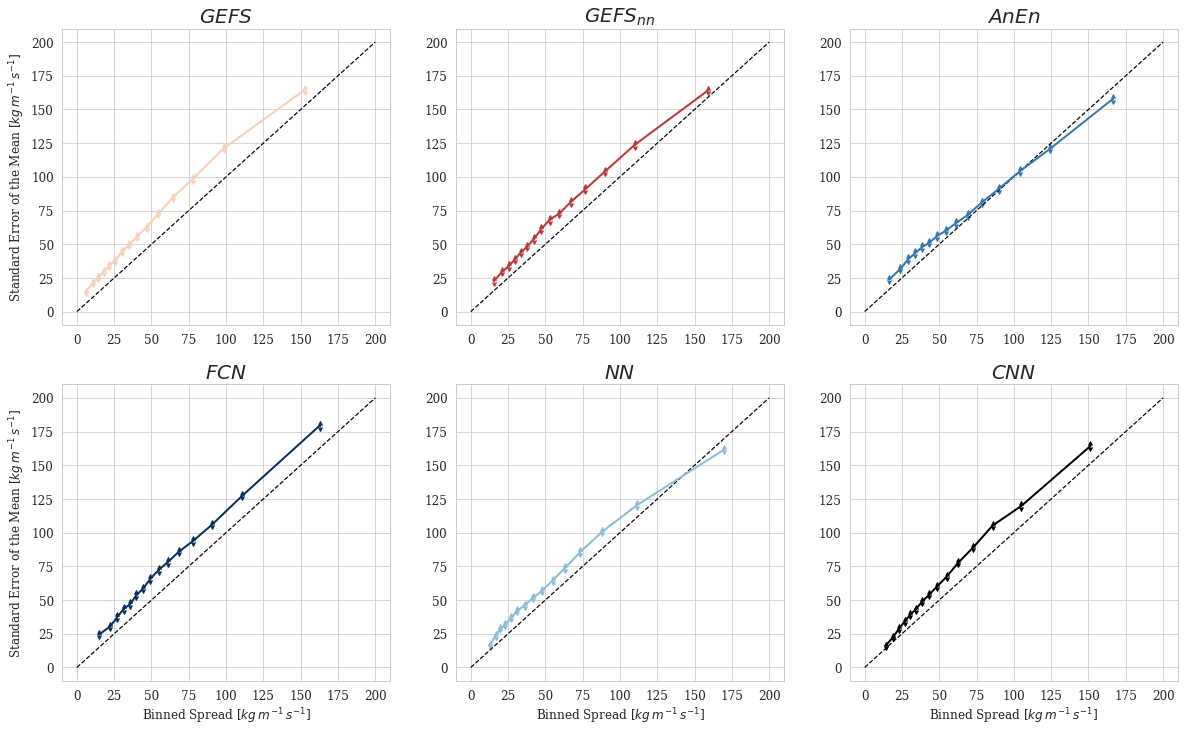

In [115]:
ticksize = 12
titsize = 20
fig, axs = plt.subplots(2, 3,figsize=(20,12))

axs[0, 0].errorbar(avgvar_m4, (msebin_m4), xerr=avgvar_s4, yerr=msebin_s4, uplims=True, lolims=True,color=SScolors['$GEFS$'],linewidth=2,label='$GEFS$')
axs[0, 0].set_ylabel('Standard Error of the Mean $[kg \:  m^{-1} \: s^{-1}]$',fontsize=12)
axs[0, 0].plot([0,200],[0,200],'k--')
axs[0, 0].set_title('$GEFS$',fontsize=titsize)
axs[0, 0].tick_params(labelsize=ticksize)

axs[0, 1].errorbar(avgvar_m2, (msebin_m2), xerr=avgvar_s2, yerr=msebin_s2, uplims=True, lolims=True,color=SScolors['$GEFS_{nn}$'],linewidth=2,label='$GEFS_{nn}$')
axs[0, 1].set_title('$GEFS_{nn}$',fontsize=20)
axs[0, 1].plot([0,200],[0,200],'k--')
axs[0, 1].tick_params(labelsize=ticksize)


axs[0, 2].errorbar(avgvar_m3, (msebin_m3), xerr=avgvar_s3, yerr=msebin_s3, uplims=True, lolims=True,color=SScolors['$AnEn$'],linewidth=2,label='$AnEn$')
axs[0, 2].set_title('$AnEn$',fontsize=20)
axs[0, 2].plot([0,200],[0,200],'k--')
axs[0, 2].tick_params(labelsize=ticksize)


axs[1, 0].errorbar(avgvar_m5, (msebin_m5), xerr=avgvar_s5, yerr=msebin_s5, uplims=True, lolims=True,color=SScolors['$FCN$'],linewidth=2,label='$FCN$')
axs[1, 0].set_ylabel('Standard Error of the Mean $[kg \:  m^{-1} \: s^{-1}]$',fontsize=12)
axs[1, 0].set_xlabel('Binned Spread $[kg \:  m^{-1} \: s^{-1}]$',fontsize=12)
axs[1, 0].set_title('$FCN$',fontsize=20)
axs[1, 0].plot([0,200],[0,200],'k--')
axs[1, 0].tick_params(labelsize=ticksize)

axs[1, 1].errorbar(avgvar_m, (msebin_m), xerr=avgvar_s, yerr=msebin_s, uplims=True, lolims=True,color=SScolors['$NN$'],linewidth=2,label='$NN$')
axs[1, 1].set_title('$NN$',fontsize=20)
axs[1, 1].set_xlabel('Binned Spread $[kg \:  m^{-1} \: s^{-1}]$',fontsize=12)
axs[1, 1].plot([0,200],[0,200],'k--')
axs[1, 1].tick_params(labelsize=ticksize)

axs[1, 2].errorbar(avgvar_m1, (msebin_m1), xerr=avgvar_s1, yerr=msebin_s1, uplims=True, lolims=True,color=SScolors['$CNN$'],linewidth=2,label='$CNN$')
axs[1, 2].set_title('$CNN$',fontsize=20)
axs[1, 2].set_xlabel('Binned Spread $[kg \:  m^{-1} \: s^{-1}]$',fontsize=12)
axs[1, 2].plot([0,200],[0,200],'k--')
axs[1, 2].tick_params(labelsize=ticksize)

plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/SpreadSkill_054_126_noleg.png',dpi = 300,bbox_inches='tight')
plt.show()

## Assesment of "perfect" calibrated stratification:

In [6]:
def delle_2006(positions,numense):
    freqi = np.histogram(positions,bins=numense+1,density = True)[0]
    perfi = 1/(numense+1)
    score = np.sum(np.abs(freqi - perfi))
    print('######## RI: ', score, "#############")
    return freqi,perfi,score

No Post-Processing
computing ranks
computing ties
computing ranks
computing ties
computing ranks
computing ties
making figure... takes FOREVER


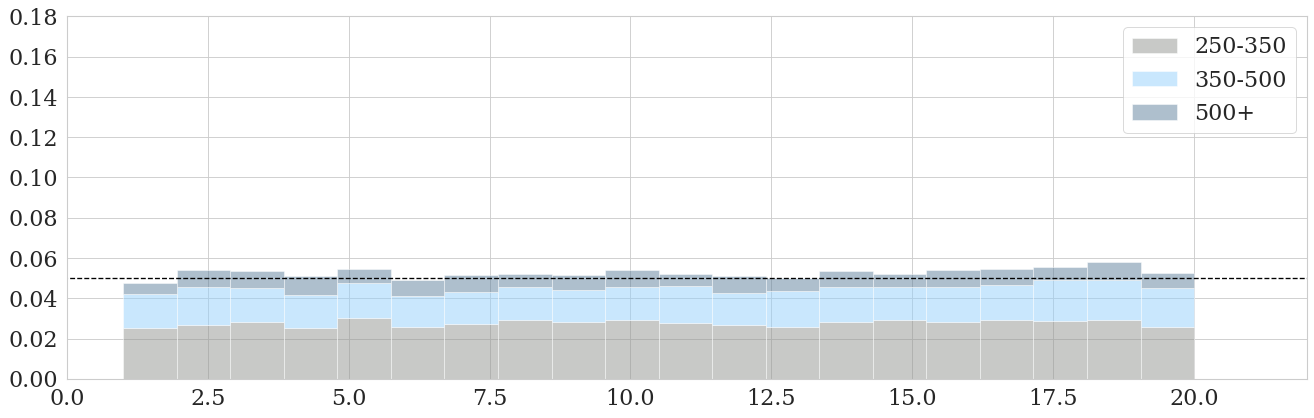

perf ref:
######## RI:  0.05909616447996768 #############
perf ref:


In [40]:
ense = 20
bins = ense # one less becasue we remove an ensemble... 
fcast='F048'
mod = 'Raw_gefs'
Thresher=0

df,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
bounds = [[250,350],[350,500],[500,10000]]


rr2 = []
for bb in bounds:
    if mod == 'AnEn':
        sss_All=np.array(df.filter(regex='Analog'))
        s_All = Post_s
        m_All = Post_m

    else:
        sss_All = np.zeros([len(Post_m),ense])
        s_All = np.zeros(len(Post_m))
        m_All = np.zeros(len(Post_m))

        for ii in range(len(Post_m)):
            sss = np.random.normal(Post_m[ii],Post_s[ii],ense)
            s_All[ii]=Post_s[ii]
            m_All[ii]=Post_m[ii]
            sss_All[ii,:] =(sss) 
    
        sss_All[sss_All<0]=0
    
    randgrab = np.random.randint(ense,size=sss_All.shape[0])
    Obs = np.array([sss_All[aa,randgrab[aa]] for aa in range(sss_All.shape[0])])
    Forecast_ense =  np.zeros([sss_All.shape[0],sss_All.shape[1]-1])
    
    for ii in range( Forecast_ense.shape[0]):
        Forecast_ense[ii,:] = sss_All[ii,np.arange(sss_All.shape[1])!=randgrab[ii]]
        
    Obs = Obs+np.random.rand(sss_All.shape[0])
    rr2.append(utils_verif.ranker(Obs[(m_All>bb[0]) & (m_All<bb[1])],np.transpose(Forecast_ense[(m_All>bb[0]) & (m_All<bb[1])])))
    


print('making figure... takes FOREVER')
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['250-350','350-500','500+'],color=sns.xkcd_palette(['grey','light blue','greyish blue']))
plt.plot([-10,80],[1/(ense),1/(ense)],'k--')
plt.legend(fontsize=20)
plt.ylim([0,0.18])
plt.xlim([0,bins+2])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


# # plt.savefig('/glade/scratch/wchapman/Reforecast/models/RankHist_'+fcast+'_ThreshOBS250_ForecastHour.png',dpi = 300,bbox_inches='tight')
plt.show()

print('perf ref:')
fri, perfi, ss = delle_2006(np.concatenate([rr2[0],rr2[1],rr2[2]]),ense-1)
print('perf ref:')

# Stratified Rank Histograms and Table 2 stats

# Figure 7

In [202]:
ense = 40
bins = ense+1
fcast='F072'
mod = 'CNNft_ref'

df,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)

if mod == 'AnEn':
    sss_All=np.array(df.filter(regex='Analog'))
    s_All = Post_s
    m_All = Post_m
    ense = 40
    bins = ense+1
    
else:
    sss_All = np.zeros([len(Post_m),ense])
    s_All = np.zeros(len(Post_m))
    m_All = np.zeros(len(Post_m))

    for ii in range(len(Post_m)):
        sss = np.random.normal(Post_m[ii],Post_s[ii],ense)
        s_All[ii]=Post_s[ii]
        m_All[ii]=Post_m[ii]
        sss_All[ii,:] =(sss) 
    
    sss_All[sss_All<0]=0

In [51]:
bounds = [[250,350],[350,450],[450,10000]]

In [236]:
mods = ['CNNft_ref','MV_gefs','Raw_gefs','AnEn','NN_ref']
utils_verif.load_forecast(fcast,mod)
pcrt = [np.array([80,90]),np.array([90,95]),np.array([95,100])]

fortts=np.array([])
for mod in mods:
    df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
    fortts=np.concatenate([fortts,np.array(Post_m)])
    bounds =[]
    for bb in pcrt:
        bounds.append([np.percentile(fortts,bb[0]),np.percentile(fortts,bb[1])])
    


No Post-Processing
2016
2017
2018


In [5]:
def delle_2006(positions,numense):
    freqi = np.histogram(positions,bins=numense+1,density = True)[0]
    perfi = 1/(numense+1)
    score = np.sum(np.abs(freqi - perfi))
    print('######## RI: ', score, "#############")
    return freqi,perfi,score

doing: F054
2016
2017
2018
No Post-Processing
doing: F060
2016
2017
2018
No Post-Processing
doing: F066
2016
2017
2018
No Post-Processing
doing: F072
2016
2017
2018
No Post-Processing
doing: F078
2016
2017
2018
No Post-Processing
doing: F084
2016
2017
2018
No Post-Processing
doing: F090
2016
2017
2018
No Post-Processing
doing: F096
2016
2017
2018
No Post-Processing
doing: F102
2016
2017
2018
No Post-Processing
doing: F108
2016
2017
2018
No Post-Processing
doing: F114
2016
2017
2018
No Post-Processing
doing: F120
2016
2017
2018
No Post-Processing
these are bounds: [[250, 350], [350, 500], [500, 10000]]
computing ranks
computing ties
computing ranks
computing ties
computing ranks
computing ties
making figure... takes FOREVER
CNN ref:
######## RI:  0.14524712784711463 #############
CNN ref:


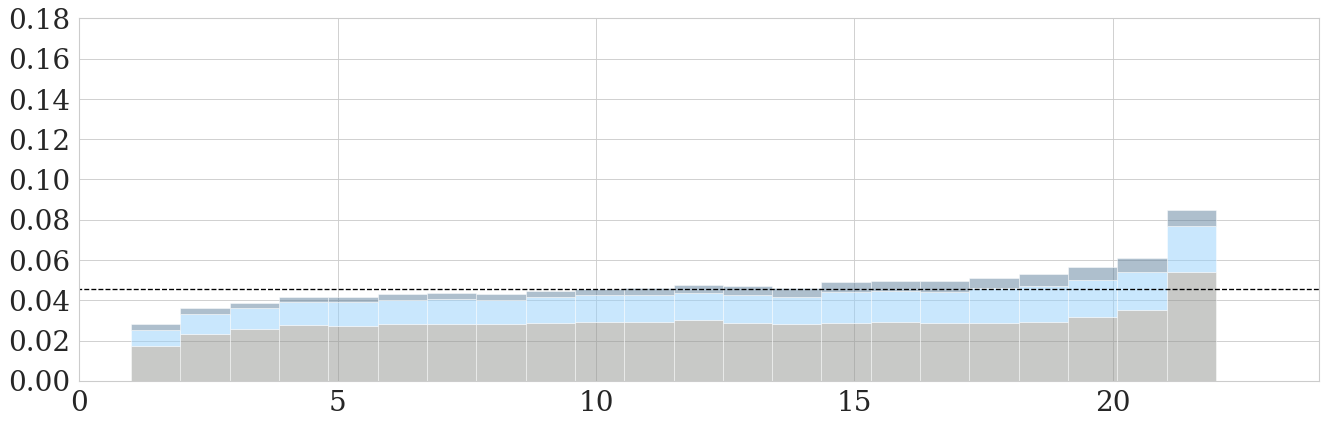

computing ranks
computing ties
computing ranks
computing ties
computing ranks
computing ties
making figure... takes FOREVER
NN Gefs:
######## RI:  0.08796532520323352 #############
NN Gefs:


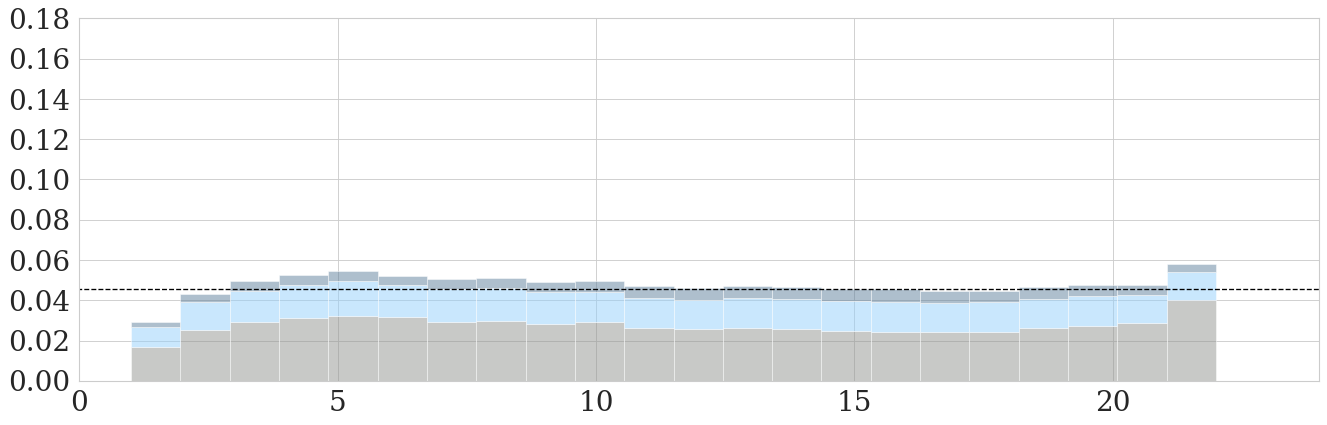

computing ranks
computing ties
computing ranks
computing ties
computing ranks
computing ties
making figure... takes FOREVER
Raw Gefs:
######## RI:  0.2560921758278186 #############
Raw Gefs:


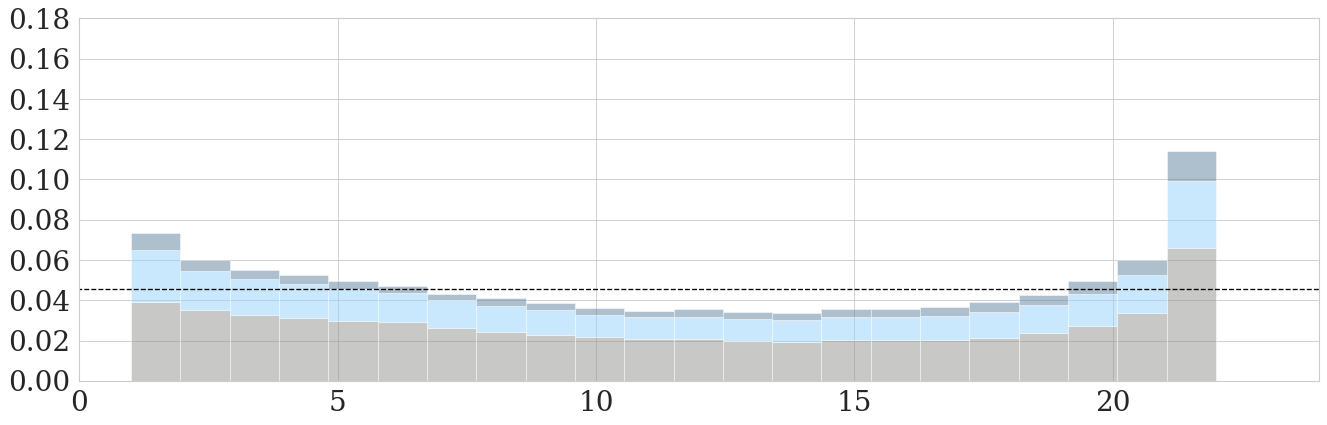

computing ranks
computing ties
computing ranks
computing ties
computing ranks
computing ties
making figure... takes FOREVER
AnEn:
######## RI:  0.08106882295855054 #############
AnEn:


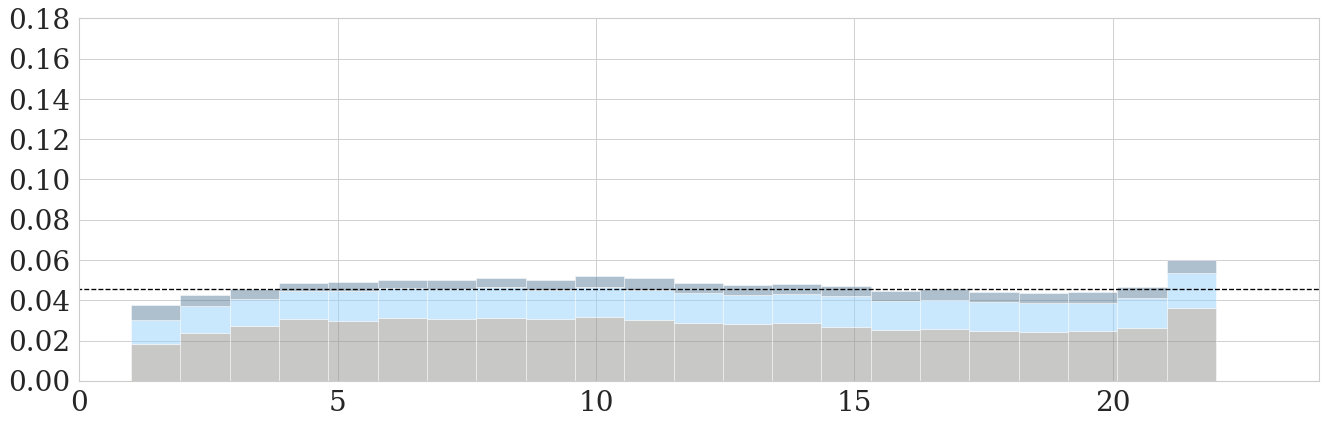

computing ranks
computing ties
computing ranks
computing ties
computing ranks
computing ties
making figure... takes FOREVER
NNref:
######## RI:  0.08424668155057179 #############
NNref:


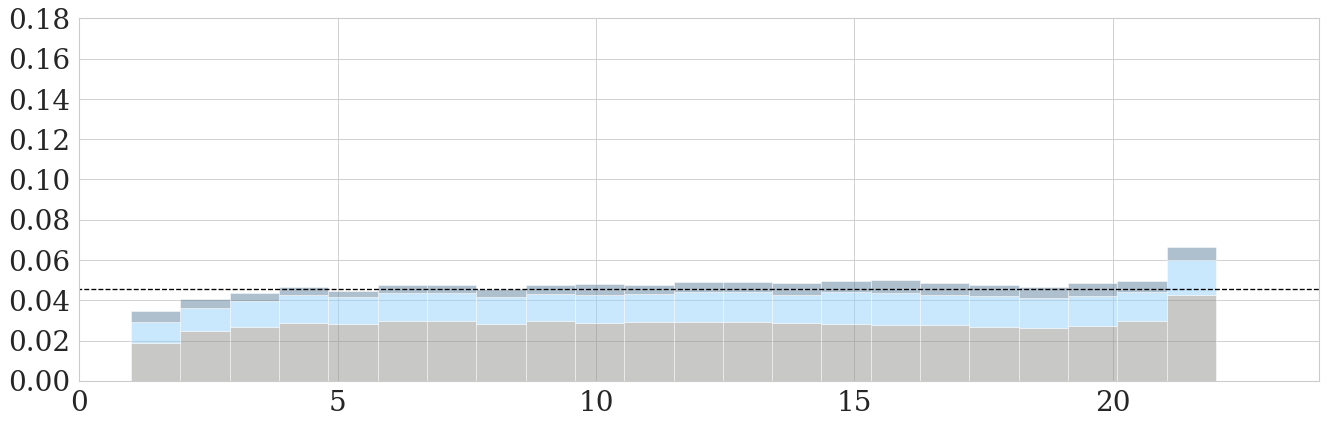

computing ranks
computing ties
computing ranks
computing ties
computing ranks
computing ties
making figure... takes FOREVER
Emos Loc:
######## RI:  0.28526170487203284 #############
Emos Loc:


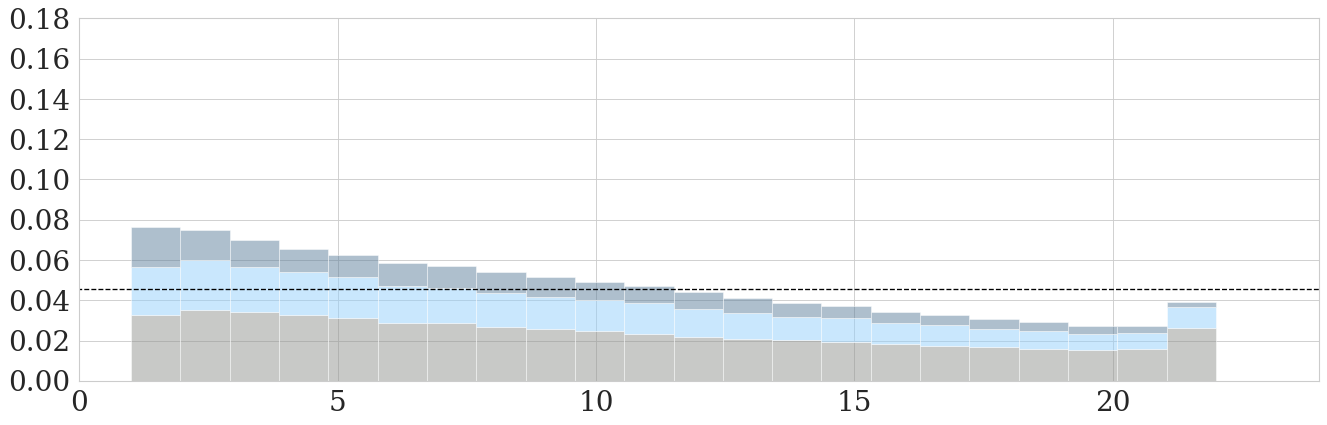

saved here: Coastal_Points_LogNormal/*_F054_F120.png


In [6]:
bounds = [[250,350],[350,500],[500,10000]]

ense = 21
bins = ense+1
topy=0.18

fcasts = ['F'+f'{bb:03}' for bb in np.arange(54,126,6)]

Post_m_c = np.array([])
Obs_c = np.array([])
Post_s_c = np.array([])

Post_m1_c = np.array([])
Obs1_c = np.array([])
Post_s1_c = np.array([])

Post_m2_c = np.array([])
Obs2_c = np.array([])
Post_s2_c = np.array([])

Post_m3_c = np.array([])
Obs3_c = np.array([])
Post_s3_c = np.array([])

Post_m4_c = np.array([])
Obs4_c = np.array([])
Post_s4_c = np.array([])

Post_m5_c = np.array([])
Obs5_c = np.array([])
Post_s5_c = np.array([])


for fcast in fcasts:
    print('doing:', fcast)
    ##
    mod = 'NN_gefs'
    df,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
    
    Post_m_c = np.concatenate([Post_m_c,Post_m])
    Obs_c = np.concatenate([Obs_c,Obs])
    Post_s_c = np.concatenate([Post_s_c,Post_s])

    ##
    mod = 'CNNft_ref'
    df1,Pre_m1, Pre_s1, Post_m1, Post_s1, Obs1 = utils_verif.load_forecast(fcast,mod)
    
    Post_m1_c = np.concatenate([Post_m1_c,Post_m1])
    Obs1_c = np.concatenate([Obs1_c,Obs1])
    Post_s1_c = np.concatenate([Post_s1_c,Post_s1])

    ##
    mod = 'NNft_ref'
    df2,Pre_m2, Pre_s2, Post_m2, Post_s2, Obs2 = utils_verif.load_forecast(fcast,mod)
    
    Post_m2_c = np.concatenate([Post_m2_c,Post_m2])
    Obs2_c = np.concatenate([Obs2_c,Obs2])
    Post_s2_c = np.concatenate([Post_s2_c,Post_s2])

    ##
    mod = 'AnEn'
    df3,Pre_m3, Pre_s3, Post_m3, Post_s3, Obs3 = utils_verif.load_forecast(fcast,mod)
    
    Post_m3_c = np.concatenate([Post_m3_c,Post_m3])
    Obs3_c = np.concatenate([Obs3_c,Obs3])
    Post_s3_c = np.concatenate([Post_s3_c,Post_s3])

    ##
    mod = 'Raw_gefs'
    df4,Pre_m4, Pre_s4, Post_m4, Post_s4, Obs4 = utils_verif.load_forecast(fcast,mod)
    
    Post_m4_c = np.concatenate([Post_m4_c,Post_m4])
    Obs4_c = np.concatenate([Obs4_c,Obs4])
    Post_s4_c = np.concatenate([Post_s4_c,Post_s4])
    
#     ##
    mod = 'EMOS'
    df5,Pre_m5, Pre_s5, Post_m5, Post_s5, Obs5 = utils_verif.load_forecast(fcast,mod)
    
    Post_m5_c = np.concatenate([Post_m5_c,Post_m5])
    Obs5_c = np.concatenate([Obs5_c,Obs5])
    Post_s5_c = np.concatenate([Post_s5_c,Post_s5])
    
    
##############
#  # calcbounds:

# mods = ['CNNft_ref','MV_gefs','Raw_gefs','AnEn','NNft_ref','NN_gefs']
# utils_verif.load_forecast(fcast,mod)
# pcrt = [np.array([80,90]),np.array([90,95]),np.array([95,100])]

# fortts=np.concatenate([Post_m_c,Post_m1_c,Post_m2_c,Post_m3_c,Post_m4_c,Post_m5_c])
# bounds =[]
# print('...making bounds...')
# for bb in pcrt:
#     bounds.append([np.percentile(fortts,bb[0]),np.percentile(fortts,bb[1])])
# ##############
print("these are bounds:",bounds)

##############################################################################################################################
## RH CNNft: 
##############################################################################################################################

rr2 = []
for bb in bounds:
    sss_All = np.zeros([len(Post_m1_c),ense])
    s_All = np.zeros(len(Post_m1_c))
    m_All = np.zeros(len(Post_m1_c))

    for ii in range(len(Post_m1_c)):
        sss = np.random.normal(Post_m1_c[ii],Post_s1_c[ii],ense)
        s_All[ii]=Post_s1_c[ii]
        m_All[ii]=Post_m1_c[ii]
        sss_All[ii,:] =(sss) 
    
    sss_All[sss_All<0]=0
    rr2.append(utils_verif.ranker(Obs1_c[(m_All>bb[0]) & (m_All<bb[1])],np.transpose(sss_All[(m_All>bb[0]) & (m_All<bb[1])])))
    
print('making figure... takes FOREVER')
print('CNN ref:')
fri, perfi, ss = delle_2006(np.concatenate([rr2[0],rr2[1],rr2[2]]),ense)
print('CNN ref:')

plt.figure(num=None, figsize=RHdict['FigSize'], dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['250-350','350-500','500+'],color=sns.xkcd_palette(['grey','light blue','greyish blue']))
plt.plot([-10,80],[1/(ense+1),1/(ense+1)],'k--')
plt.ylim([0,topy])
plt.xlim([0,bins+2])
plt.yticks(fontsize=RHdict['tickFS'])
plt.xticks(fontsize=RHdict['tickFS'])
# plt.legend(fontsize=RHdict['legendFS'],loc='upper center')


plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RH_CNNft_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
plt.show()

##############################################################################################################################
## RH NN gefs: 
##############################################################################################################################


rr2 = []
for bb in bounds:
    sss_All = np.zeros([len(Post_m_c),ense])
    s_All = np.zeros(len(Post_m_c))
    m_All = np.zeros(len(Post_m_c))

    for ii in range(len(Post_m_c)):
        sss = np.random.normal(Post_m_c[ii],Post_s_c[ii],ense)
        s_All[ii]=Post_s_c[ii]
        m_All[ii]=Post_m_c[ii]
        sss_All[ii,:] =(sss) 
    
    sss_All[sss_All<0]=0
    rr2.append(utils_verif.ranker(Obs_c[(m_All>bb[0]) & (m_All<bb[1])],np.transpose(sss_All[(m_All>bb[0]) & (m_All<bb[1])])))
    
print('making figure... takes FOREVER')
print('NN Gefs:')
fri, perfi, ss = delle_2006(np.concatenate([rr2[0],rr2[1],rr2[2]]),ense)
print('NN Gefs:')

plt.figure(num=None, figsize=RHdict['FigSize'], dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['250-350','350-500','500+'],color=sns.xkcd_palette(['grey','light blue','greyish blue']))
plt.plot([-10,80],[1/(ense+1),1/(ense+1)],'k--')
plt.ylim([0,topy])
plt.xlim([0,bins+2])
plt.yticks(fontsize=RHdict['tickFS'])
plt.xticks(fontsize=RHdict['tickFS'])
# plt.legend(fontsize=RHdict['legendFS'],loc='upper center')


plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RH_NNgefs_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
plt.show()



##############################################################################################################################
## Raw Gefs: 
##############################################################################################################################


rr2 = []
for bb in bounds:
    sss_All = np.zeros([len(Post_m4_c),ense])
    s_All = np.zeros(len(Post_m4_c))
    m_All = np.zeros(len(Post_m4_c))

    for ii in range(len(Post_m4_c)):
        sss = np.random.normal(Post_m4_c[ii],Post_s4_c[ii],ense)
        s_All[ii]=Post_s4_c[ii]
        m_All[ii]=Post_m4_c[ii]
        sss_All[ii,:] =(sss) 
    
    sss_All[sss_All<0]=0
    rr2.append(utils_verif.ranker(Obs4_c[(m_All>bb[0]) & (m_All<bb[1])],np.transpose(sss_All[(m_All>bb[0]) & (m_All<bb[1])])))
    
print('making figure... takes FOREVER')
print('Raw Gefs:')
fri, perfi, ss = delle_2006(np.concatenate([rr2[0],rr2[1],rr2[2]]),ense)
print('Raw Gefs:')

plt.figure(num=None, figsize=RHdict['FigSize'], dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['250-350','350-500','500+'],color=sns.xkcd_palette(['grey','light blue','greyish blue']))
plt.plot([-10,80],[1/(ense+1),1/(ense+1)],'k--')
plt.ylim([0,topy])
plt.xlim([0,bins+2])
plt.yticks(fontsize=RHdict['tickFS'])
plt.xticks(fontsize=RHdict['tickFS'])
# plt.legend(fontsize=RHdict['legendFS'],loc='upper center')


plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RH_RAWgefs_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
plt.show()


##############################################################################################################################
## AnEn: 
##############################################################################################################################


rr2 = []
for bb in bounds:
    sss_All = np.zeros([len(Post_m3_c),ense])
    s_All = np.zeros(len(Post_m3_c))
    m_All = np.zeros(len(Post_m3_c))

    for ii in range(len(Post_m3_c)):
        sss = np.random.normal(Post_m3_c[ii],Post_s3_c[ii],ense)
        s_All[ii]=Post_s3_c[ii]
        m_All[ii]=Post_m3_c[ii]
        sss_All[ii,:] =(sss) 
    
    sss_All[sss_All<0]=0
    rr2.append(utils_verif.ranker(Obs3_c[(m_All>bb[0]) & (m_All<bb[1])],np.transpose(sss_All[(m_All>bb[0]) & (m_All<bb[1])])))
    
print('making figure... takes FOREVER')
print('AnEn:')
fri, perfi, ss = delle_2006(np.concatenate([rr2[0],rr2[1],rr2[2]]),ense)
print('AnEn:')

plt.figure(num=None, figsize=RHdict['FigSize'], dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['250-350','350-500','500+'],color=sns.xkcd_palette(['grey','light blue','greyish blue']))
plt.plot([-10,80],[1/(ense+1),1/(ense+1)],'k--')
plt.ylim([0,topy])
plt.xlim([0,bins+2])
plt.yticks(fontsize=RHdict['tickFS'])
plt.xticks(fontsize=RHdict['tickFS'])
# plt.legend(fontsize=RHdict['legendFS'],loc='upper center')


plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RH_AnEn_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
plt.show()


#############################################################################################################################
# NNft ref: 
#############################################################################################################################


rr2 = []
for bb in bounds:
    sss_All = np.zeros([len(Post_m2_c),ense])
    s_All = np.zeros(len(Post_m2_c))
    m_All = np.zeros(len(Post_m2_c))

    for ii in range(len(Post_m2_c)):
        sss = np.random.normal(Post_m2_c[ii],Post_s2_c[ii],ense)
        s_All[ii]=Post_s2_c[ii]
        m_All[ii]=Post_m2_c[ii]
        sss_All[ii,:] =(sss) 
    
    sss_All[sss_All<0]=0
    rr2.append(utils_verif.ranker(Obs2_c[(m_All>bb[0]) & (m_All<bb[1])],np.transpose(sss_All[(m_All>bb[0]) & (m_All<bb[1])])))
    
print('making figure... takes FOREVER')
print('NNref:')
fri, perfi, ss = delle_2006(np.concatenate([rr2[0],rr2[1],rr2[2]]),ense)
print('NNref:')


plt.figure(num=None, figsize=RHdict['FigSize'], dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['250-350','350-500','500+'],color=sns.xkcd_palette(['grey','light blue','greyish blue']))
plt.plot([-10,80],[1/(ense+1),1/(ense+1)],'k--')
plt.ylim([0,topy])
plt.xlim([0,bins+2])
plt.yticks(fontsize=RHdict['tickFS'])
plt.xticks(fontsize=RHdict['tickFS'])
# plt.legend(fontsize=RHdict['legendFS'],loc='upper center')


plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RH_NNref_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
plt.show()


#############################################################################################################################
# MV Gefs: 
#############################################################################################################################


rr2 = []
for bb in bounds:
    sss_All = np.zeros([len(Post_m5_c),ense])
    s_All = np.zeros(len(Post_m5_c))
    m_All = np.zeros(len(Post_m5_c))

    for ii in range(len(Post_m5_c)):
        sss = np.random.normal(Post_m5_c[ii],Post_s5_c[ii],ense)
        s_All[ii]=Post_s5_c[ii]
        m_All[ii]=Post_m5_c[ii]
        sss_All[ii,:] =(sss) 
    
    sss_All[sss_All<0]=0
    rr2.append(utils_verif.ranker(Obs5_c[(m_All>bb[0]) & (m_All<bb[1])],np.transpose(sss_All[(m_All>bb[0]) & (m_All<bb[1])])))
    
print('making figure... takes FOREVER')
print('Emos Loc:')
fri, perfi, ss = delle_2006(np.concatenate([rr2[0],rr2[1],rr2[2]]),ense)
print('Emos Loc:')


plt.figure(num=None, figsize=RHdict['FigSize'], dpi=80, facecolor='w', edgecolor='k')
# plt.hist(rr,density=True,bins=30,alpha=0.4,label='AnEn')
plt.hist(rr2,bins=bins,density = True,stacked=True,alpha=0.5,label=['250-350','350-500','500+'],color=sns.xkcd_palette(['grey','light blue','greyish blue']))
plt.plot([-10,80],[1/(ense+1),1/(ense+1)],'k--')
plt.ylim([0,topy])
plt.xlim([0,bins+2])
plt.yticks(fontsize=RHdict['tickFS'])
plt.xticks(fontsize=RHdict['tickFS'])
# plt.legend(fontsize=RHdict['legendFS'],loc='upper center')


plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RH_EMOSref_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
plt.show()


print('saved here:', 'Coastal_Points_LogNormal/*_'+fcasts[0]+'_'+fcasts[-1]+'.png')


# Reliability Diagrams

doing model: CNNft_ref
Threshold: 250
making reliability diagram


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


computing climatology
computing no skill line


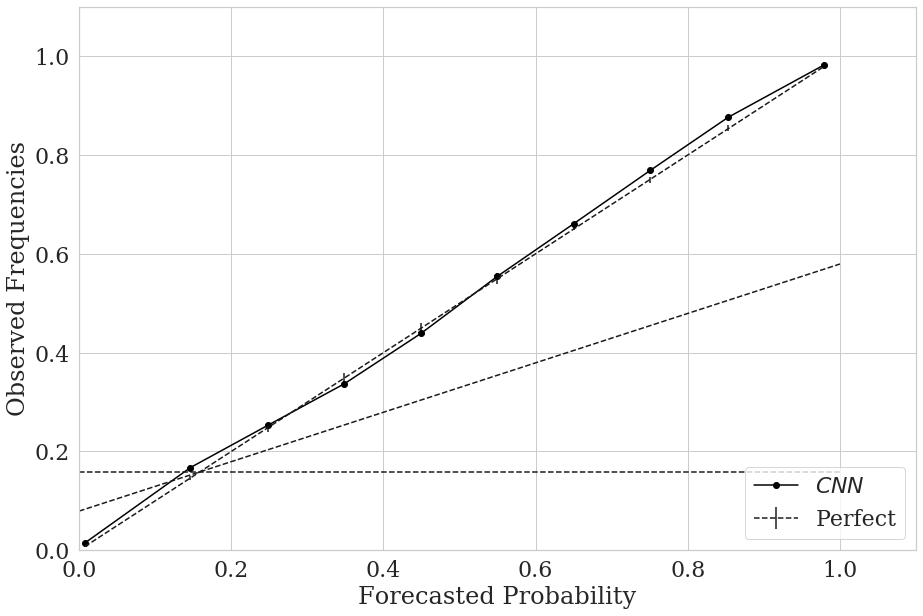

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_CNNft_ref_thresh_250_ForecastHour_F000_F048.png


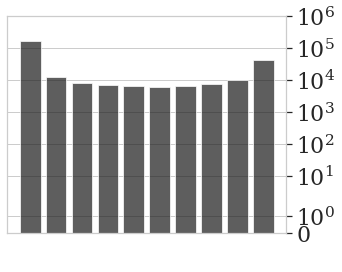

doing model: NN_gefs
Threshold: 250
making reliability diagram


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


computing climatology
computing no skill line


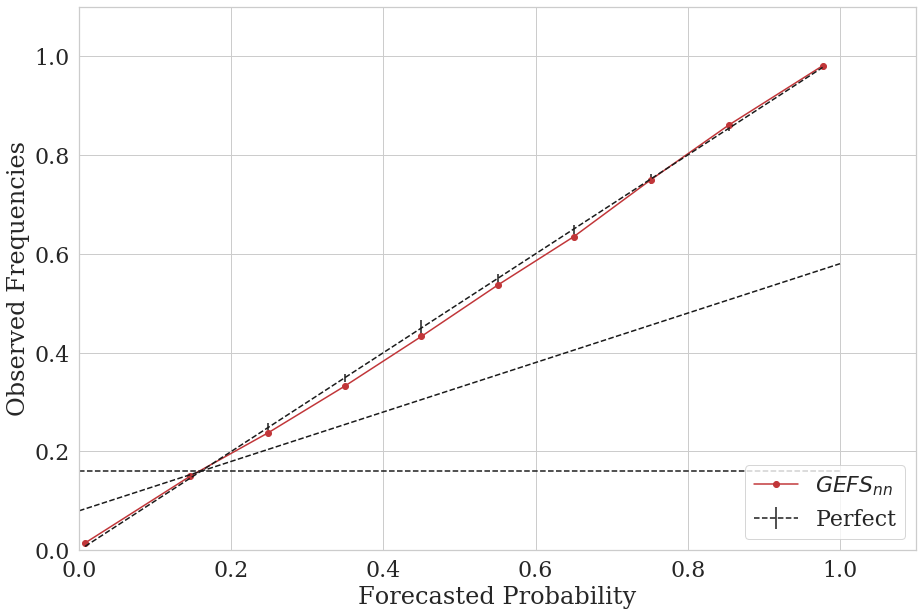

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_NN_gefs_thresh_250_ForecastHour_F000_F048.png


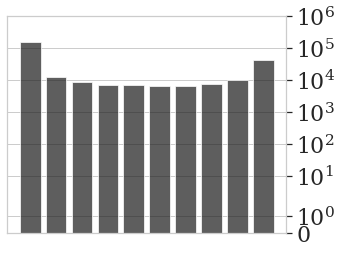

doing model: NN_ref
Threshold: 250
making reliability diagram


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


computing climatology
computing no skill line


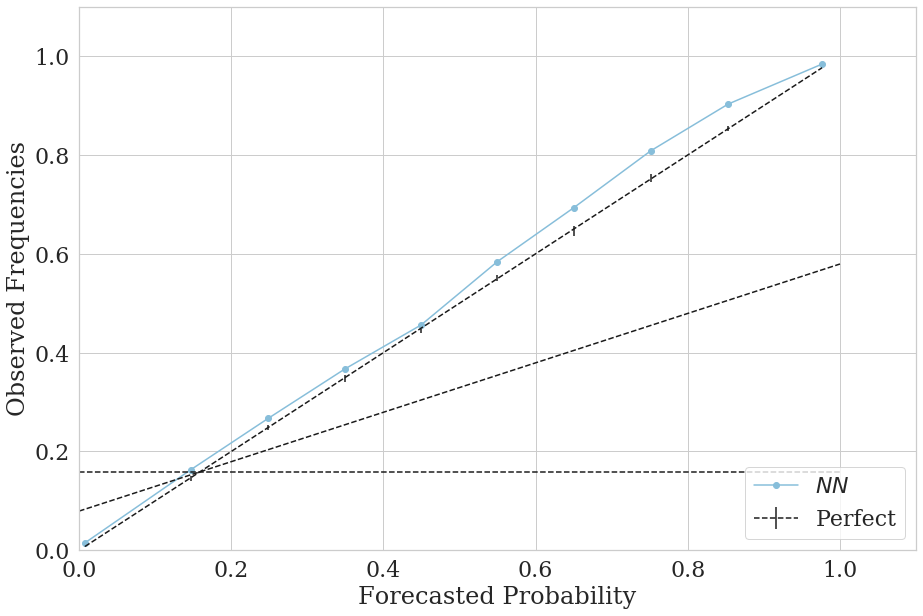

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_NN_ref_thresh_250_ForecastHour_F000_F048.png


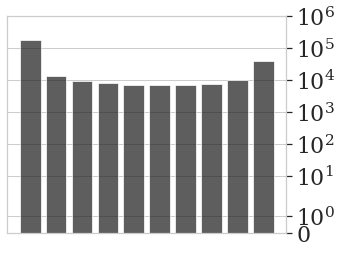

doing model: AnEn
2016
2017
2018
2016
2017
2018
2016
2017
2018
2016
2017
2018
2016
2017
2018
2016
2017
2018
2016
2017
2018
2016
2017
2018
2016
2017
2018
Threshold: 250
making reliability diagram


100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


computing climatology
computing no skill line


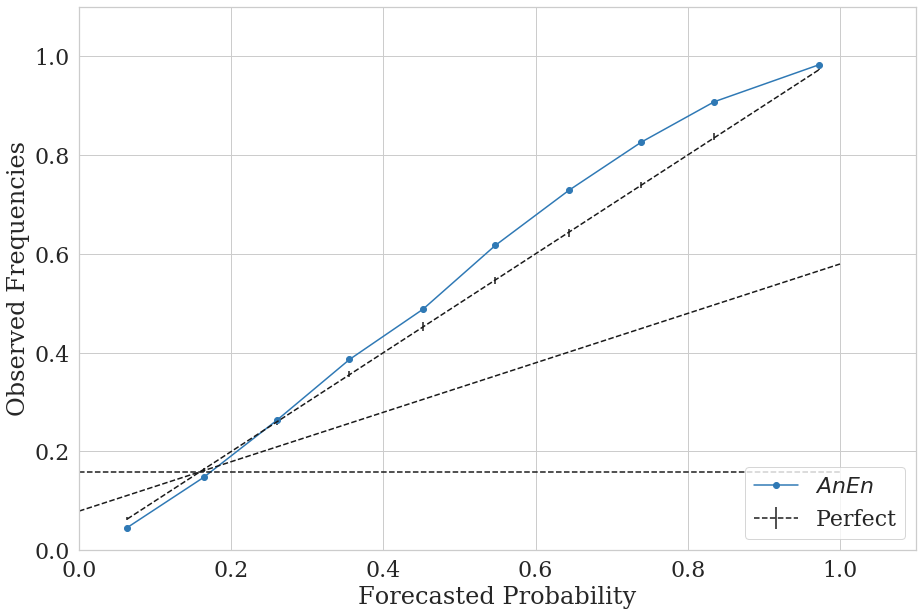

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_AnEn_thresh_250_ForecastHour_F000_F048.png


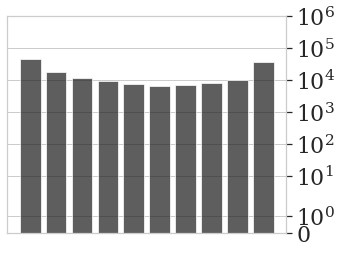

doing model: Raw_gefs
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
Threshold: 250
making reliability diagram


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


computing climatology
computing no skill line


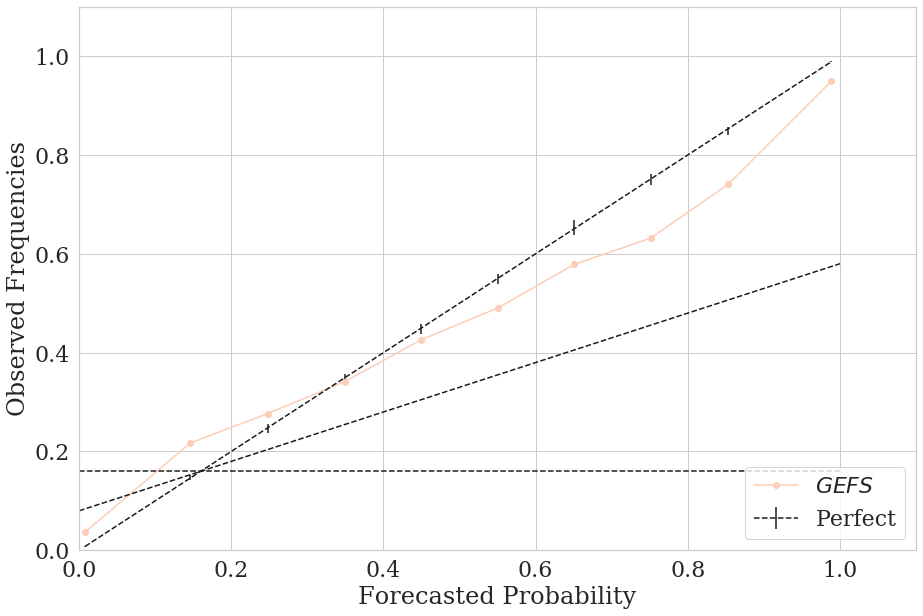

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_Raw_gefs_thresh_250_ForecastHour_F000_F048.png


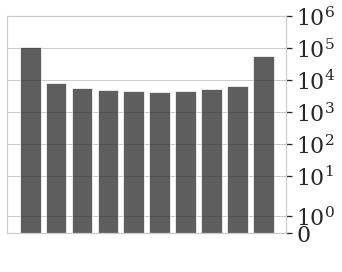

doing model: EMOS
Threshold: 250
making reliability diagram


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


computing climatology
computing no skill line


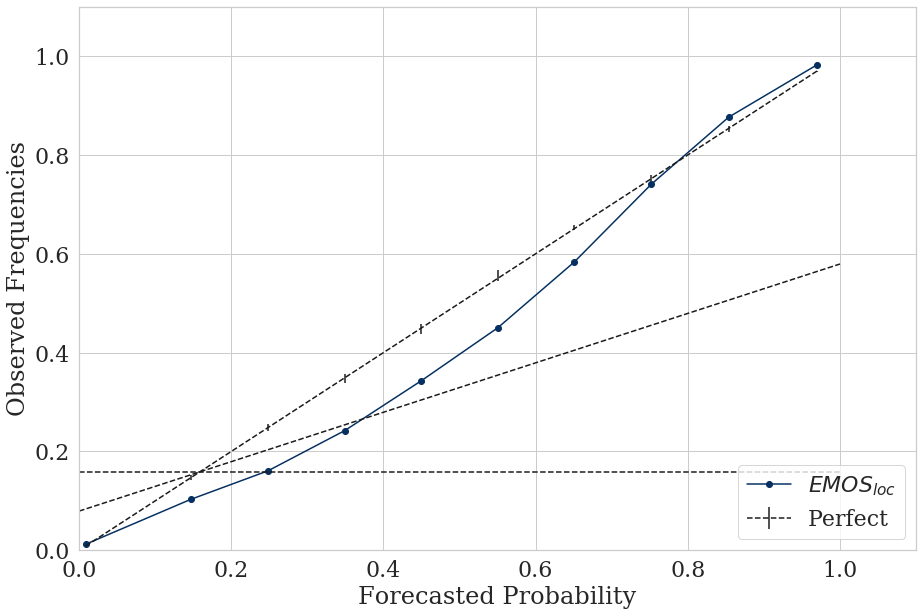

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_EMOS_thresh_250_ForecastHour_F000_F048.png


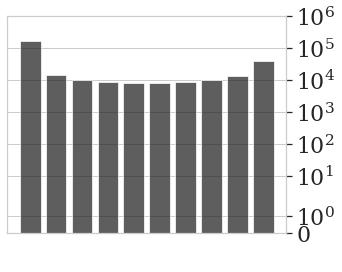

In [60]:
mods = ['CNNft_ref','NN_gefs','NN_ref','AnEn','Raw_gefs','EMOS']
modscol = ['$CNN$','$GEFS_{nn}$','$NN$','$AnEn$','$GEFS$','$FCN$']

mods = ['EMOS']
modscol = ['$FCN$']

b_siz=0.1
threshes=[250,350,500] #85,95,95
# threshes=[250] #85,95,95

fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,54,6)]
for thresh in threshes:
    for juju, mod in enumerate(mods):
        print('doing model:', mod)
        LF ,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast_concat(fcasts,mod)
        print('Threshold:', thresh)

        if mod == 'AnEn':
            LF["truth"]=1*(LF['OBS']>thresh)
            LF["predicted"]=1*(Post_m>thresh)
            ensems = np.array(LF.filter(regex="Analog"))
            percOthresh = []
            for bb in range(len(LF)):
                percOthresh.append(np.sum(1*(ensems[bb,:]>thresh))/ensems[bb,:].shape[0])

            #concatenate confidences and lat/lon locations
            LF['confidences']=percOthresh
            LF.head()
        else: 
            LF["truth"]=1*(LF['OBS']>thresh)
            LF["predicted"]=1*(Post_m>thresh)
            ff = np.stack([Post_m,Post_s]).T
            percOthresh = utils_verif.prob_ob(thresh,ff[:,0],ff[:,1])
            LF['confidences']=percOthresh

        predictions = LF["predicted"]
        truth = LF["truth"]
        confidences = LF["confidences"]
        print('making reliability diagram')
        [AnEnplot_x,AnEnnew_plot_x, AnEnnew_accs,AnEnlower_bars,AnEnupper_bars]=utils_verif.reliability_diagrams(predictions[0:], truth[0:], confidences[0:],bin_size=b_siz, n_boot=10)
        print('computing climatology')
        climo = np.sum(truth)/truth.shape[0]
        print('computing no skill line')
        pt1 = np.array([climo,climo])
        pt2 = np.array([1,(1+climo)/2])
        slp = (pt2[1]-pt1[1])/(pt2[0]-pt1[0])
        b = pt1[0] - slp*pt1[0]
    
    
        ##plot and save
        sns.set(font_scale=2) 
        sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
        plt.figure(figsize=[15,10])  # inches
        plt.errorbar(AnEnplot_x, AnEnplot_x, yerr=[AnEnlower_bars, AnEnupper_bars], label="Perfect",color='k',linestyle='--')
        plt.plot(AnEnnew_plot_x, AnEnnew_accs, '-o', label=modscol[juju], color=SScolors[modscol[juju]])
        plt.plot([0,1],[climo,climo],'k--')
        plt.plot([0,pt2[0]],[b,pt2[1]],'k--')
        plt.ylim([0,1.1])
        plt.xlim([0,1.1])
        plt.ylabel('Observed Frequencies')
        plt.xlabel('Forecasted Probability')
        plt.legend(loc='lower right')
        # plt.title('AnEn, Threshold: '+str(thresh)+ '; Forecast: ' + fcast)
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
        plt.show()
        print('saving: ','/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png')
        upper_bounds = np.arange(1,len(np.arange(b_siz, 1+b_siz, b_siz))+1)
        f= plt.figure(figsize=[5,4])
        ax = f.add_subplot(111)
        plot = plt.bar(upper_bounds, (utils_verif.freq_hist(confidences,bin_size=0.1)),color='k',alpha=0.7)
        ax.grid(False,axis='x')
        plt.yscale('symlog')
        ax.yaxis.tick_right()
        plt.xticks(upper_bounds, " ")
        plt.ylim([0,10**6])
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_Hist_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
        plt.show()

In [ ]:
mods = ['CNNft_ref','NN_gefs','NN_ref','AnEn','Raw_gefs']
modscol = ['$CNN$','$GEFS_{nn}$','$NN$','$AnEn$','$GEFS$']
b_siz=0.1
threshes=[250,350,450,500] #85,95,95
fcasts = ['F'+f'{bb:03}' for bb in np.arange(54,126,6)]
for thresh in threshes:
    for juju, mod in enumerate(mods):
        print('doing model:', mod)
        LF ,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast_concat(fcasts,mod)
#         thresh = np.percentile(Post_m,percy)
#         thresh = 250
        print('Threshold:', thresh)

        if mod == 'AnEn':
            LF["truth"]=1*(LF['OBS']>thresh)
            LF["predicted"]=1*(Post_m>thresh)
            ensems = np.array(LF.filter(regex="Analog"))
            percOthresh = []
            for bb in range(len(LF)):
                percOthresh.append(np.sum(1*(ensems[bb,:]>thresh))/ensems[bb,:].shape[0])

            #concatenate confidences and lat/lon locations
            LF['confidences']=percOthresh
            LF.head()
        else: 
            LF["truth"]=1*(LF['OBS']>thresh)
            LF["predicted"]=1*(Post_m>thresh)
            ff = np.stack([Post_m,Post_s]).T
            percOthresh = utils_verif.prob_ob(thresh,ff[:,0],ff[:,1])
            LF['confidences']=percOthresh

        predictions = LF["predicted"]
        truth = LF["truth"]
        confidences = LF["confidences"]
        print('making reliability diagram')
        [AnEnplot_x,AnEnnew_plot_x, AnEnnew_accs,AnEnlower_bars,AnEnupper_bars]=utils_verif.reliability_diagrams(predictions[0:], truth[0:], confidences[0:],bin_size=b_siz, n_boot=500)
        print('computing climatology')
        climo = np.sum(truth)/truth.shape[0]
        print('computing no skill line')
        pt1 = np.array([climo,climo])
        pt2 = np.array([1,(1+climo)/2])
        slp = (pt2[1]-pt1[1])/(pt2[0]-pt1[0])
        b = pt1[0] - slp*pt1[0]
    
    
        ##plot and save
        sns.set(font_scale=2) 
        sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
        plt.figure(figsize=[15,10])  # inches
        plt.errorbar(AnEnplot_x, AnEnplot_x, yerr=[AnEnlower_bars, AnEnupper_bars], label="Perfect",color='k',linestyle='--')
        plt.plot(AnEnnew_plot_x, AnEnnew_accs, '-o', label=modscol[juju], color=SScolors[modscol[juju]])
        plt.plot([0,1],[climo,climo],'k--')
        plt.plot([0,pt2[0]],[b,pt2[1]],'k--')
        plt.ylim([0,1.1])
        plt.xlim([0,1.1])
        plt.ylabel('Observed Frequencies')
        plt.xlabel('Forecasted Probability')
        plt.legend(loc='lower right')
        # plt.title('AnEn, Threshold: '+str(thresh)+ '; Forecast: ' + fcast)
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
        plt.show()
        print('saving: ','/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png')
        upper_bounds = np.arange(1,len(np.arange(b_siz, 1+b_siz, b_siz))+1)
        f= plt.figure(figsize=[5,4])
        ax = f.add_subplot(111)
        plot = plt.bar(upper_bounds, (utils_verif.freq_hist(confidences,bin_size=0.1)),color='k',alpha=0.7)
        ax.grid(False,axis='x')
        plt.yscale('symlog')
        ax.yaxis.tick_right()
        plt.ylim([0,10**6])
        plt.xticks(upper_bounds, " ")
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_Hist_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
        plt.show()

doing model: CNNft_ref
Threshold: 250
making reliability diagram


100%|█████████▉| 498/500 [37:53<00:09,  4.92s/it]

doing model: Raw_gefs
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
Threshold: 250
making reliability diagram


100%|██████████| 500/500 [06:25<00:00,  1.30it/s]


computing climatology
computing no skill line


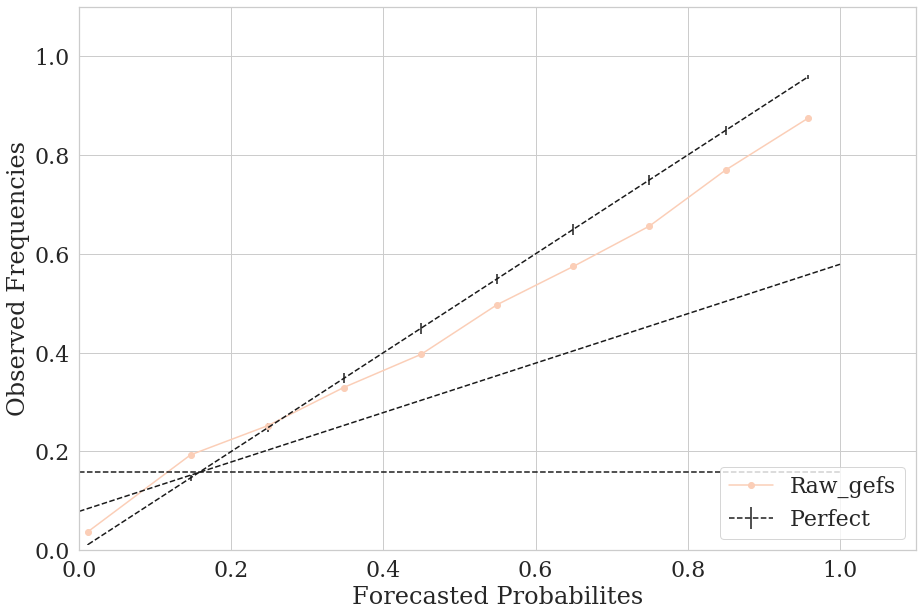

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_Raw_gefs_thresh_250_ForecastHour_F096_F120.png


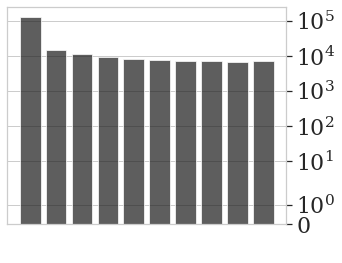

doing model: Raw_gefs
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
Threshold: 500
making reliability diagram


100%|██████████| 500/500 [05:38<00:00,  1.48it/s]


computing climatology
computing no skill line


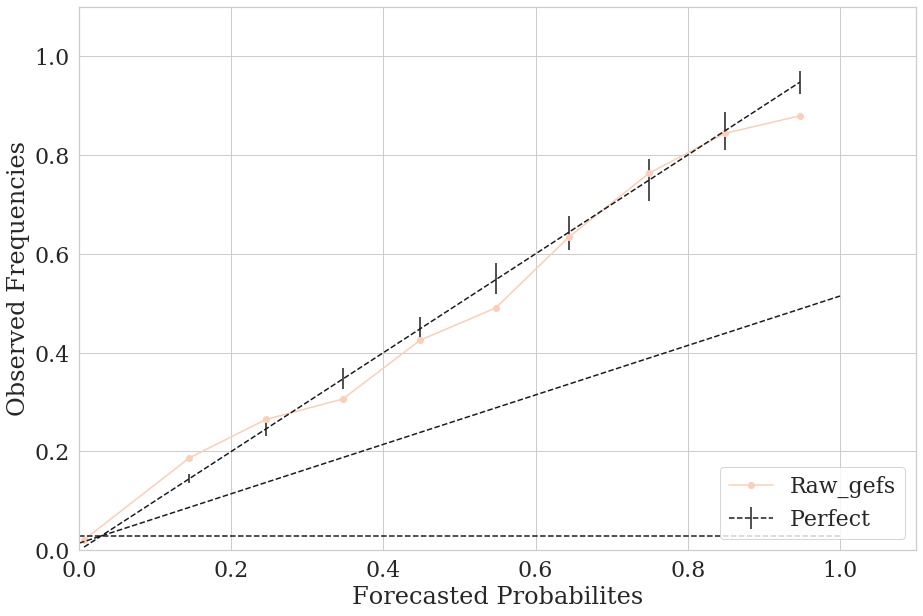

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_Raw_gefs_thresh_500_ForecastHour_F096_F120.png


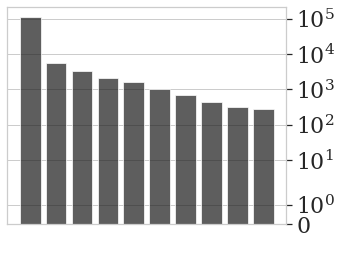

doing model: Raw_gefs
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
No Post-Processing
Threshold: 750
making reliability diagram


100%|██████████| 500/500 [05:28<00:00,  1.52it/s]


computing climatology
computing no skill line


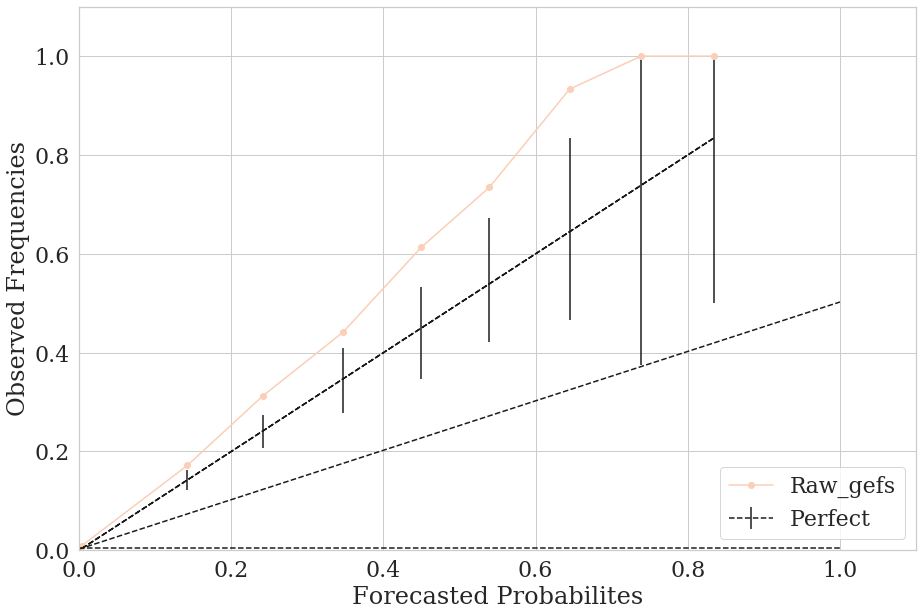

saving:  /glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_Raw_gefs_thresh_750_ForecastHour_F096_F120.png


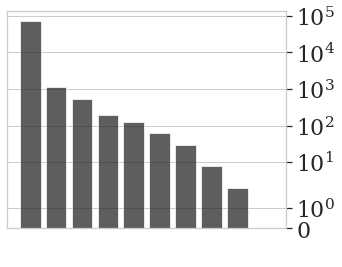

In [54]:
mods = ['Raw_gefs']
b_siz=0.1
threshes=[250,500,750]
fcasts = ['F'+f'{bb:03}' for bb in np.arange(96,126,6)]
for thresh in threshes:
    for mod in mods:
        print('doing model:', mod)
        LF ,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast_concat(fcasts,mod)
#         thresh = np.percentile(Post_m,percy)
#         thresh = 250
        print('Threshold:', thresh)

        if mod == 'AnEn':
            LF["truth"]=1*(LF['OBS']>thresh)
            LF["predicted"]=1*(Post_m>thresh)
            ensems = np.array(LF.filter(regex="Analog"))
            percOthresh = []
            for bb in range(len(LF)):
                percOthresh.append(np.sum(1*(ensems[bb,:]>thresh))/ensems[bb,:].shape[0])

            #concatenate confidences and lat/lon locations
            LF['confidences']=percOthresh
            LF.head()
        else: 
            LF["truth"]=1*(LF['OBS']>thresh)
            LF["predicted"]=1*(Post_m>thresh)
            ff = np.stack([Post_m,Post_s]).T
            percOthresh = utils_verif.prob_ob(thresh,ff[:,0],ff[:,1])
            LF['confidences']=percOthresh

        predictions = LF["predicted"]
        truth = LF["truth"]
        confidences = LF["confidences"]
        print('making reliability diagram')
        [AnEnplot_x,AnEnnew_plot_x, AnEnnew_accs,AnEnlower_bars,AnEnupper_bars]=utils_verif.reliability_diagrams(predictions[0:], truth[0:], confidences[0:],bin_size=b_siz, n_boot=500)
        print('computing climatology')
        climo = np.sum(truth)/truth.shape[0]
        print('computing no skill line')
        pt1 = np.array([climo,climo])
        pt2 = np.array([1,(1+climo)/2])
        slp = (pt2[1]-pt1[1])/(pt2[0]-pt1[0])
        b = pt1[0] - slp*pt1[0]
    
    
        ##plot and save
        sns.set(font_scale=2) 
        sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
        plt.figure(figsize=[15,10])  # inches
        plt.errorbar(AnEnplot_x, AnEnplot_x, yerr=[AnEnlower_bars, AnEnupper_bars], label="Perfect",color='k',linestyle='--')
        plt.plot(AnEnnew_plot_x, AnEnnew_accs, '-o', label=mod, color=SScolors[mod])
        plt.plot([0,1],[climo,climo],'k--')
        plt.plot([0,pt2[0]],[b,pt2[1]],'k--')
        plt.ylim([0,1.1])
        plt.xlim([0,1.1])
        plt.ylabel('Observed Frequencies')
        plt.xlabel('Forecasted Probabilites')
        plt.legend(loc='lower right')
        # plt.title('AnEn, Threshold: '+str(thresh)+ '; Forecast: ' + fcast)
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
        plt.show()
        print('saving: ','/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png')
        upper_bounds = np.arange(1,len(np.arange(b_siz, 1+b_siz, b_siz))+1)
        f= plt.figure(figsize=[5,4])
        ax = f.add_subplot(111)
        plot = plt.bar(upper_bounds, (utils_verif.freq_hist(confidences,bin_size=0.1)),color='k',alpha=0.7)
        ax.grid(False,axis='x')
        plt.yscale('symlog')
        ax.yaxis.tick_right()
        plt.xticks(upper_bounds, " ")
        plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_Hist_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
        plt.show()

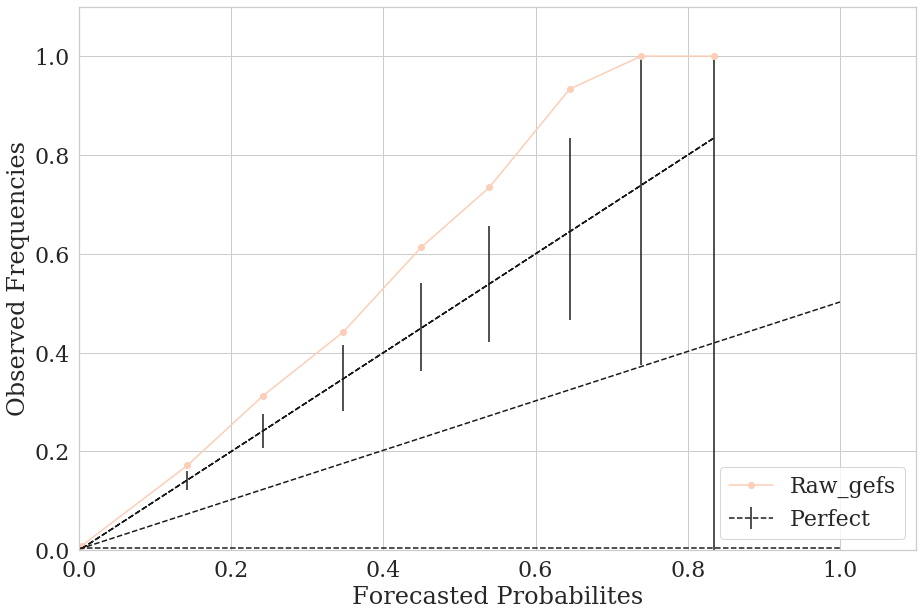

In [52]:
sns.set(font_scale=2) 
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman','font_scale':2})
plt.figure(figsize=[15,10])  # inches
plt.errorbar(AnEnplot_x, AnEnplot_x, yerr=[AnEnlower_bars, AnEnupper_bars], label="Perfect",color='k',linestyle='--')
plt.plot(AnEnnew_plot_x, AnEnnew_accs, '-o', label=mod, color=SScolors[mod])
plt.plot([0,1],[climo,climo],'k--')
plt.plot([0,pt2[0]],[b,pt2[1]],'k--')
plt.ylim([0,1.1])
plt.xlim([0,1.1])
plt.ylabel('Observed Frequencies')
plt.xlabel('Forecasted Probabilites')
plt.legend(loc='lower right')
#         # plt.title('AnEn, Threshold: '+str(thresh)+ '; Forecast: ' + fcast)
#         plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Reliability_'+(mod)+'_thresh_'+str(thresh)+'_ForecastHour_'+fcasts[0]+'_'+fcasts[-1]+'.png',dpi = 300,bbox_inches='tight')
plt.show()

# Map of Points:

## Region of interest

In [92]:
stepnum=9

dd = '/glade/scratch/wchapman/Reforecast/'
os.chdir(dd)

yago= next(os.walk('.'))[1]
yago = sorted(yago)
subs = 'F'
res = [ii for ii in yago if subs in ii] 
res
for fcast in res[:stepnum]: 
    os.chdir(dd+'/'+fcast)
    print(os.getcwd())
  
                                                                                                                                               
print('Training on')
path = os.getcwd()
train_file_names = sorted([f for f in glob.glob(path + "/train/*_500mb.nc", recursive=True)])
for f in train_file_names:
    print(f)

print('Validating on')
validate_file_names = sorted([f for f in glob.glob(path + "/validate/*_500mb.nc", recursive=True)])
for f in validate_file_names:
    print(f)
    
print('Testing on')
test_file_names = sorted([f for f in glob.glob(path + "/test/*_500mb.nc", recursive=True)])
for f in test_file_names:
    print(f)
    
All_file_names =train_file_names + validate_file_names +test_file_names 

DS = xr.open_mfdataset(All_file_names)
IVT = DS['IVT'].data
IVTm = DS['IVTm'].data
lat = DS['lat'].data
lon = DS['lon'].data

array([22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
       55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ])

2016
2017
2018
...Searching...: /glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/
number of points: 144


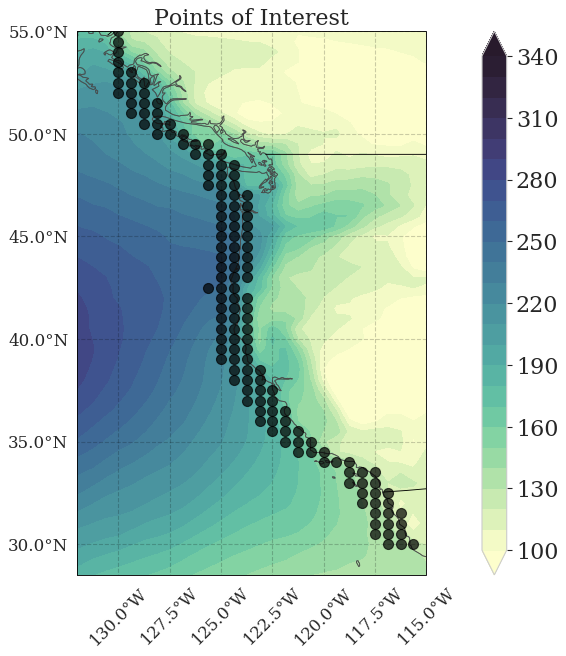

In [300]:
dd = '/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/'
os.chdir(dd)
LeadTime = 'F120'
ENS=40
tot = utilsAnEn.load_picks([2016,2017,2018],LeadTime,ENS)
latlonfolder = '/glade/scratch/wchapman/AnEnCNN_good/Data/WestCoast/'
lat = np.arange(22,60.5,.5)
lon = np.arange(200.0,249.375+.625,.625)
MapPoints = np.zeros([lat.shape[0],lon.shape[0]])
print('...Searching...:',latlonfolder)
path = latlonfolder
pp_file_names = [f for f in glob.glob(path + "/lat*lon*", recursive=True)]
pp_file_names = sorted(pp_file_names)
latp=[]
lonp=[]

for ff in pp_file_names:
    #find the appropriate lat/lon index
    ff2 = ff.split('lat')[1]
    ff3 = (ff2.split('lon'))
    
    latp.append(float(ff3[0]))
    lonp.append(float(ff3[1])-360)
    
#     latfind = float(ff3[0])
#     lonfind = float(ff3[1])
#     indlat= np.where(lat==latfind)[0][0]
#     indlon= np.where(lon==lonfind)[0][0]
#     y_tst = np.array(tot[(tot['lat']==latfind) & (tot['lon']==lonfind)]['OBS'])
#     m = np.array(np.mean(tot[(tot['lat']==latfind) & (tot['lon']==lonfind)].filter(regex='Analog'),axis=1))
#     MapPoints[indlat,indlon] = utilsAnEn.rmse(m,y_tst)
    
# MapPoints[MapPoints==0]=np.nan
print("number of points:", len(pp_file_names))


##################### plotting ###############################

fig = plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
cmap1 = matplotlib.cm.get_cmap("plasma",lut=25)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1,projection = proj)

ax.set_xticks(np.linspace(-135,-110, 11), crs=proj)
ax.set_yticks(np.linspace(30, 60, 7), crs=proj)


feature = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='50m',
    edgecolor='#000000', facecolor='none')
ax.add_feature(feature)

feature = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='50m',
    facecolor="none",alpha=0.3)
ax.add_feature(feature)
ax.add_feature(cf.BORDERS)

# ax.coastlines(resolution='50m')
ax.set_extent([-132, -115, 28.5, 55])

lon_formatter = LongitudeFormatter(number_format='.1f',
                                       dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f')
ax.xaxis.set_major_formatter(lon_formatter)
# ax.xaxis.(fontsize=25)
ax.yaxis.set_major_formatter(lat_formatter)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)

scales = 1
ff =  plt.plot(np.squeeze(lonp),np.squeeze(latp),'ko',markersize=9,alpha=.7)

lat = DS['lat'].data
lon = DS['lon'].data
ff =  plt.contourf(np.squeeze(lon),np.squeeze(lat),RMSEivt,np.arange(100,350,10),extend = 'both',cmap=cmocean.cm.deep)
cc=plt.colorbar()
cc.ax.tick_params(labelsize=20) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.2, linestyle='--', draw_labels=False)
gl.xlocator = mticker.FixedLocator(np.linspace(-135,-110, 11))
gl.ylocator = mticker.FixedLocator(np.linspace(20, 60, 9))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


plt.title('Points of Interest',fontsize=20)

plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/StatsROI_Points.png',dpi = 300,bbox_inches='tight')
plt.show()
# plt.close('all')

In [274]:
import cartopy.feature as cfeature

In [145]:
stepnum=9

dd = '/glade/scratch/wchapman/Reforecast/'
os.chdir(dd)

yago= next(os.walk('.'))[1]
yago = sorted(yago)
subs = 'F'
res = [ii for ii in yago if subs in ii] 
res
for fcast in res[:stepnum]: 
    os.chdir(dd+'/'+fcast)
    print(os.getcwd())
  
                                                                                                                                               
print('Training on')
path = os.getcwd()
train_file_names = sorted([f for f in glob.glob(path + "/train/*_500mb.nc", recursive=True)])
for f in train_file_names:
    print(f)

print('Validating on')
validate_file_names = sorted([f for f in glob.glob(path + "/validate/*_500mb.nc", recursive=True)])
for f in validate_file_names:
    print(f)
    
print('Testing on')
test_file_names = sorted([f for f in glob.glob(path + "/test/*_500mb.nc", recursive=True)])
for f in test_file_names:
    print(f)
    
All_file_names =train_file_names + validate_file_names +test_file_names 

DS = xr.open_mfdataset(All_file_names)
IVT = DS['IVT'].data
IVTm = DS['IVTm'].data
lat = DS['lat'].data
lon = DS['lon'].data

/glade/scratch/wchapman/Reforecast/F000
/glade/scratch/wchapman/Reforecast/F006
/glade/scratch/wchapman/Reforecast/F012
/glade/scratch/wchapman/Reforecast/F018
/glade/scratch/wchapman/Reforecast/F024
/glade/scratch/wchapman/Reforecast/F030
/glade/scratch/wchapman/Reforecast/F036
/glade/scratch/wchapman/Reforecast/F042
/glade/scratch/wchapman/Reforecast/F048
Training on
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1985_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1986_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1987_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1988_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1989_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1990_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1991_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1992_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1993_500mb.nc
/glade/scratch/w

/glade/scratch/wchapman/Reforecast/F000
/glade/scratch/wchapman/Reforecast/F006
/glade/scratch/wchapman/Reforecast/F012
/glade/scratch/wchapman/Reforecast/F018
/glade/scratch/wchapman/Reforecast/F024
/glade/scratch/wchapman/Reforecast/F030
/glade/scratch/wchapman/Reforecast/F036
/glade/scratch/wchapman/Reforecast/F042
/glade/scratch/wchapman/Reforecast/F048
Training on
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1985_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1986_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1987_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1988_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1989_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1990_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1991_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1992_500mb.nc
/glade/scratch/wchapman/Reforecast/F048/train/F048_WY_1993_500mb.nc
/glade/scratch/w

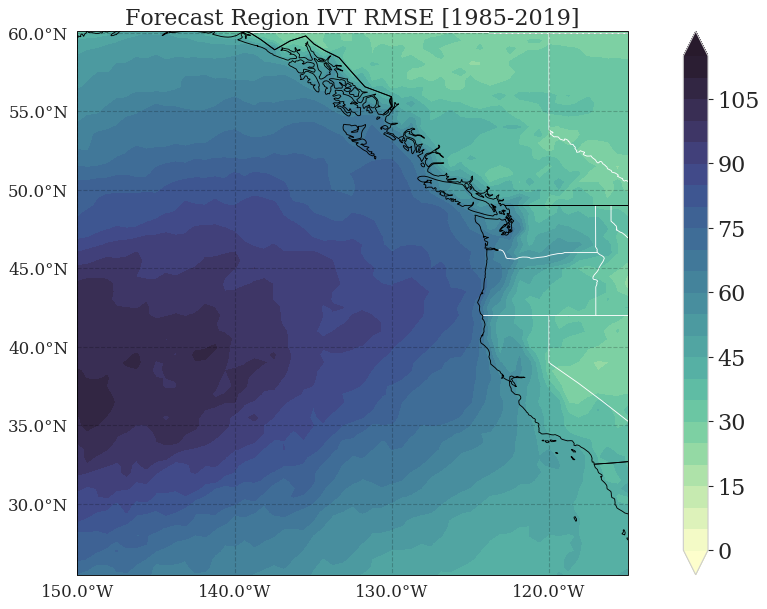

In [292]:
##################### plotting ###############################
##################### plotting ###############################
##################### plotting ###############################
##################### plotting ###############################
##################### plotting ###############################
##################### plotting ###############################

RMSEivt = np.sqrt(np.mean((IVT - IVTm)**2,axis=0))


##################### plotting ###############################

fig = plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
cmap1 = matplotlib.cm.get_cmap("plasma",lut=25)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1,projection = proj)
ax.add_feature(cf.BORDERS)
ff =  plt.contourf(np.squeeze(lon),np.squeeze(lat),RMSEivt,np.arange(0,120,5),extend = 'both',cmap=cmocean.cm.deep)
cc=plt.colorbar()
cc.ax.tick_params(labelsize=20) 

ax.set_xticks(np.linspace(-150,-100, 6), crs=proj)
ax.set_yticks(np.linspace(20, 60, 9), crs=proj)
ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines(resolution='50m')
ax.add_feature(cf.BORDERS)
ax.set_extent([-150, -115, 25.5, 59])

lon_formatter = LongitudeFormatter(number_format='.1f',
                                       dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f')
ax.xaxis.set_major_formatter(lon_formatter)
# ax.xaxis.(fontsize=25)
ax.yaxis.set_major_formatter(lat_formatter)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.2, linestyle='--', draw_labels=False)
gl.xlocator = mticker.FixedLocator([ -150, -140, -130.,-120.,-110.])
gl.ylocator = mticker.FixedLocator(np.linspace(20, 60, 9))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ax.gridlines(draw_labels=False)
plt.title('Forecast Region IVT RMSE [1985-2019]',fontsize=20)
plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/RMSE_ROI.png',dpi = 300,bbox_inches='tight')
plt.show()
# plt.close('all')

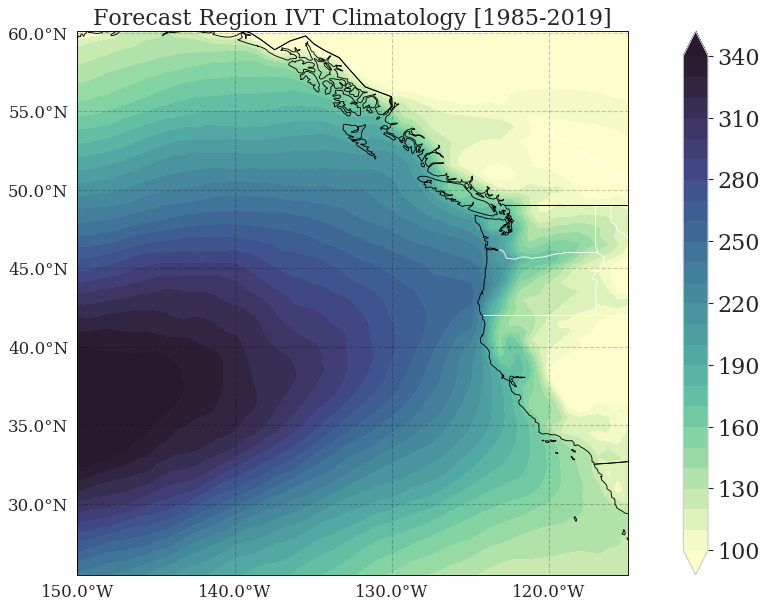

In [293]:
RMSEivt = np.sqrt(np.mean((IVT - IVTm)**2,axis=0))
RMSEivt = np.sqrt(np.mean((IVTm)**2,axis=0))

##################### plotting ###############################

fig = plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
cmap1 = matplotlib.cm.get_cmap("plasma",lut=25)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1,projection = proj)
ax.add_feature(cf.BORDERS)
ff =  plt.contourf(np.squeeze(lon),np.squeeze(lat),RMSEivt,np.arange(100,350,10),extend = 'both',cmap=cmocean.cm.deep)
cc=plt.colorbar()
cc.ax.tick_params(labelsize=20) 


ax.set_xticks(np.linspace(-150,-100, 6), crs=proj)
ax.set_yticks(np.linspace(20, 60, 9), crs=proj)
ax.add_feature(cf.NaturalEarthFeature(
               category='cultural',
               name='admin_1_states_provinces_lines',
               scale='50m',
               facecolor='none'))

ax.coastlines(resolution='50m')
ax.add_feature(cf.BORDERS)
ax.set_extent([-150, -115, 25.5, 59])

lon_formatter = LongitudeFormatter(number_format='.1f',
                                       dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f')
ax.xaxis.set_major_formatter(lon_formatter)
# ax.xaxis.(fontsize=25)
ax.yaxis.set_major_formatter(lat_formatter)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.2, linestyle='--', draw_labels=False)
gl.xlocator = mticker.FixedLocator([ -150, -140, -130.,-120.,-110.])
gl.ylocator = mticker.FixedLocator(np.linspace(20, 60, 9))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# ax.gridlines(draw_labels=False)
plt.title('Forecast Region IVT Climatology [1985-2019]',fontsize=20)
plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/Climo_ROI.png',dpi = 300,bbox_inches='tight')
plt.show()
# plt.close('all')

## TW AnEn by training year

In [3]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def f_emp(ens,x):
    xs,ys = ecdf(ens)
    vals=[]
    vals = np.zeros([len(x)])
    for bb,xT in enumerate(x):
        if all(xs>xT):
            vals[bb] = 0
        elif (np.sum(1*(xs>xT))>0) & (np.sum(1*(xs>xT))<len(xs)):
            inds = np.searchsorted(xs>xT, 0.5)
            vals[bb] =ys[inds-1]
        else:
            vals[bb] = 1
    return np.array(vals)

def f_emp2(ens,x):
    xs,ys = ecdf(ens)
    dogs = np.searchsorted(xs,x,side='right')
    vals =ys[dogs-1]
    vals[dogs==0]=0
    return np.array(vals)

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
#     print((f_emp(ens,eval_z).shape))
    out = np.sum(w(eval_z)*((f_emp(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out

### computation of threshold-weighted CRPS via numerical approximation suggested by Gneiting & Ranjan (2011)
def twcrps_sample2(y,ens,weight,thr,step_width=0.001):
    #y = real-valued observation (numpy array)
    #ens = vector of ensemble forecasts (numpy array)
    #thr = threshold parameter for weight function
    # weight = charactor vector identifying the employed weight function:
    #     "indicator.right": Indicator weight function for right tail
    #     "indicator.left": Indicator weight function for left tail
    #     "normalCDF.right": Gaussian weight function for right tail, mean = thr, and sd = 1
    #     "normalCDF.left": Gaussian weight function for right tail, mean = thr, and sd = 1
    # lower, upper: bounds for interval of evaluation points
    # step.width: increment of the sequence of evaluation points

    lower = np.min(np.append(ens,y))
    upper = np.max(np.append(ens,y))
    eval_z = np.arange(lower,upper,step_width)
    if weight not in ['indicator.right','indicator.left','normalCDF.right','normalCDF.left']:
        raise ValueError("weight function not specified correctly")
        
    if weight =='indicator.right':
        def w(z):return z>=thr
    elif weight =='indicator.left':
        def w(z):return z<=thr
    elif weight == 'normalCDF.right':
        def w(z):return stats.norm.cdf(z, loc=thr, scale=1)
    elif weight == 'normalCDF.left':
        def w(z):return 1-stats.norm.cdf(z, loc=thr, scale=1)
    
#     print(eval_z.shape)
#     print((f_emp2(ens,eval_z).shape))
    
    out = np.sum(w(eval_z)*((f_emp2(ens,eval_z)-(y<=eval_z)))**2)*(upper-lower)/len(eval_z)
    return out


In [44]:
df2 = utilsAnEn.load_picks_year([2016,2017,2018],fcast,40,yearzz)
df2 = df2.rename(columns={'OBS':'OBSanen2','Model':'Reforecast_AnEn2','IVTmean':'IVTmean_anen2','IVTstd':'IVTstd_anen2'})
df2['AnEn_Mean2'] = np.mean(df2.filter(regex='Analog'),axis=1)
df2['AnEn_std2'] = np.std(df2.filter(regex='Analog'),axis=1)
df2['time']= df2['Issued_Time']+ timedelta(hours=int(fcast[-3:]))
df2 = df2.drop(columns=df2.filter(regex='Analog').columns[:].tolist())

2016
./AnEn/Analog_Total_Bias_300_100_2016_startingyear_1993.pkl
2017
./AnEn/Analog_Total_Bias_300_100_2017_startingyear_1993.pkl
2018
./AnEn/Analog_Total_Bias_300_100_2018_startingyear_1993.pkl


,Fname,Issued_Time,lead_hr,LT,OBSanen2,Reforecast_AnEn2,lat,lon,AnEn_Mean2,AnEn_std2,time
8,/data/downloaded/Forecasts/Machine_Learning/Re...,2016-12-01,F048,8.0,95.1423,89.4911,30.0,243.125,81.132307,24.895366,2016-12-03
29,/data/downloaded/Forecasts/Machine_Learning/Re...,2016-12-02,F048,8.0,134.1406,125.9952,30.0,243.125,103.329392,26.247189,2016-12-04
50,/data/downloaded/Forecasts/Machine_Learning/Re...,2016-12-03,F048,8.0,81.3112,107.6071,30.0,243.125,93.379442,39.542607,2016-12-05
71,/data/downloaded/Forecasts/Machine_Learning/Re...,2016-12-04,F048,8.0,169.1375,170.4673,30.0,243.125,157.750027,36.925185,2016-12-06
92,/data/downloaded/Forecasts/Machine_Learning/Re...,2016-12-05,F048,8.0,238.3809,285.0808,30.0,243.125,240.458447,72.595435,2016-12-07
...,...,...,...,...,...,...,...,...,...,...,...
2444,/data/downloaded/Forecasts/Machine_Learning/Re...,2019-03-27,F048,8.0,17.0106,44.9207,55.0,230.000,42.509285,26.376874,2019-03-29
2465,/data/downloaded/Forecasts/Machine_Learning/Re...,2019-03-28,F048,8.0,17.0514,24.8497,55.0,230.000,32.002677,17.665179,2019-03-30
2486,/data/downloaded/Forecasts/Machine_Learning/Re...,2019-03-29,F048,8.0,20.6277,33.9165,55.0,230.000,36.258893,25.557425,2019-03-31
2507,/data/downloaded/Forecasts/Machine_Learning/Re...,2019-03-30,F048,8.0,21.4029,28.4411,55.0,230.000,31.361308,16.533697,2019-04-01


In [138]:
dffin

,Training Years,Model,CRPS
0,1985,AnEn,0.000000
1,1985,AnEn,0.000000
2,1985,AnEn,0.000000
3,1985,AnEn,0.000000
4,1985,AnEn,0.000000
...,...,...,...
995,1990,AnEn,-0.248323
996,1990,AnEn,-0.227655
997,1990,AnEn,0.019474
998,1990,AnEn,0.337664


In [43]:
percy = 95
yearstot = np.arange(1985,2016,1)
training_years = np.arange(31,0,-1)
dffin=pd.DataFrame({'Training Years':[],'Model':[],'CRPS':[]})
df2,df4,dfm=1,1,1
fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,126,6)]
bsnummy = 1000
ense = 100


for fcast in fcasts:
    dffin=pd.DataFrame({'Training Years':[],'Model':[],'CRPS':[]})
    for indyy,yearz in enumerate(yearstot): 
        del df2
        del df4 
        
        print('doing:',fcast)
        fortts=np.array([])
        mods = ['AnEn']
        for mod in mods:
            df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
            fortts=np.concatenate([fortts,np.array(Post_m)])
            bounds =[]
            threshold = np.percentile(fortts,percy)
        ##############
        print("this is the threshold:",threshold,'for a percentile:', percy)
        ########################################################################################################
        
        mod = 'AnEn'
        df4,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df4 = df4.rename(columns={'OBS':'OBSanen','Model':'Reforecast_AnEn','IVTmean':'IVTmean_anen','IVTstd':'IVTstd_anen'})
        df4['AnEn_Mean'] = np.mean(df4.filter(regex='Analog'),axis=1)
        df4['AnEn_std'] = np.std(df4.filter(regex='Analog'),axis=1)
        df4['time']= df4['Issued_Time']+ timedelta(hours=int(fcast[-3:]))
        
        df2 = utilsAnEn.load_picks_year([2016,2017,2018],fcast,40,yearz)
        df2 = df2.rename(columns={'OBS':'OBSanen2','Model':'Reforecast_AnEn2','IVTmean':'IVTmean_anen2','IVTstd':'IVTstd_anen2'})
        df2['AnEn_Mean2'] = np.mean(df2.filter(regex='Analog'),axis=1)
        df2['AnEn_std2'] = np.std(df2.filter(regex='Analog'),axis=1)
        df2['time']= df2['Issued_Time']+ timedelta(hours=int(fcast[-3:]))
    
        #define 4 groups:        
        Ensembla = np.array(df4.filter(regex='Analog'))
        Trutha = np.array(df4['AnEn_Mean'])
        Merraa = np.array(df4['OBSanen'])
        
        Ensembla2 = np.array(df2.filter(regex='Analog'))
        Trutha2 = np.array(df2['AnEn_Mean2'])
        Merraa2 = np.array(df2['OBSanen2'])
        
        CRPStempa = np.zeros((Merraa.shape[0]))
        CRPStempa2 = np.zeros((Merraa2.shape[0]))
    
        print('calc tw-crps')

        for gre in range(0,Merraa.shape[0]):    
            if np.max(np.append(Merraa[gre],Ensembla[gre,:]))<=threshold:
                CRPStempa[gre] = 0
            else:
                CRPStempa[gre] = twcrps_sample2(Merraa[gre],Ensembla[gre,:],'indicator.right',threshold,step_width=10)
    
    
        for gre in range(0,Merraa2.shape[0]):    
            if np.max(np.append(Merraa2[gre],Ensembla2[gre,:]))<=threshold:
                CRPStempa2[gre] = 0
            else:
                CRPStempa2[gre] = twcrps_sample2(Merraa2[gre],Ensembla2[gre,:],'indicator.right',threshold,step_width=10)
    
    
        print("...boostrapping....")
#     bootstrap randomdraws:
        CRPSanen_ref = np.zeros(bsnummy)
        CRPSanen_ref2 = np.zeros(bsnummy)
        
        
        for bb in range(bsnummy):
            inss = np.random.randint(Merraa2.shape[0], size=Merraa2.shape[0])
            CRPSanen_ref[bb] = (1 - (np.mean(CRPStempa2[inss])/np.mean(CRPStempa[inss])))*100
#             CRPSanen_ref[bb] = np.mean(CRPStempa[inss])
#             CRPSanen_ref2[bb] = ((np.mean(CRPStempa2[inss])))
            
#             CRPSanen_ref[bb] = (1 - (np.mean(CRPStempa2[inss])/np.mean(CRPStempa[inss])))*100
#             CRPSanen_ref[bb] = np.mean(CRPStempa2[inss])
    
        
        #define 3 groups:  
    
        dftemp = pd.DataFrame({'CRPS':CRPSanen_ref})
        dftemp['Training Years'] = str(yearz)
        dftemp['Model'] = 'AnEn'
        dffin = pd.concat([dffin, dftemp], axis=0)
        
    plt.figure(figsize=BPdict['FigSize'])
    plt.plot([-10,35],[0,0],'k')

    ax = sns.boxplot(x="Training Years", y="CRPS", hue="Model",data=dffin,palette=mycolors,whis=[10, 90])
    plt.yticks(fontsize=BPdict['tickFS'])
    plt.xticks(fontsize=BPdict['tickFS'],rotation=45)
    plt.ylabel('[%]',fontsize=BPdict['labelFS'])
    plt.xlabel('Lead',fontsize=BPdict['labelFS'])
    plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
    plt.title('twCRPS',fontsize=BPdict['titleFS'])
    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_AnEn_By_Year_'+fcast+'_Perc_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')
    plt.show() 
        
        
        

# for bb in np.arange(-0.5,22,1):
#     plt.plot([bb,bb],[-.6,.2],'k--')

# plt.ylim([-.15,.21])
# plt.xlim([-0.5,10.5])
# plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_percentile'+str(percy)+'.png',dpi = 300,bbox_inches='tight')

plt.show()
        
        
        
#         dftemp = pd.DataFrame({'CRPS':CRPSanen_ref2})
#         dftemp['Training Years'] = str(yearz)
#         dftemp['Model'] = 'AnEn_year'
#         dffin = pd.concat([dffin, dftemp], axis=0)
#         print('...done...')

#     plt.figure(figsize=BPdict['FigSize'])
#     plt.plot([-10,23],[0,0],'k')

#     ax = sns.boxplot(x="Lead", y="CRPS", hue="Model",data=dffin, palette=mycolors,whis=[10, 90])
#     plt.yticks(fontsize=BPdict['tickFS'])
#     plt.xticks(fontsize=BPdict['tickFS'])
#     plt.ylabel('[%]',fontsize=BPdict['labelFS'])
#     plt.xlabel('Lead',fontsize=BPdict['labelFS'])
#     plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
#     plt.title('twCRPS',fontsize=BPdict['titleFS'])

#     for bb in np.arange(-0.5,22,1):
#         plt.plot([bb,bb],[-.6,.2],'k--')

#     plt.ylim([-.15,.21])
#     plt.xlim([-0.5,10.5])
#     plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_percentile'+str(percy)+'.png',dpi = 300,bbox_inches='tight')

#     plt.show()




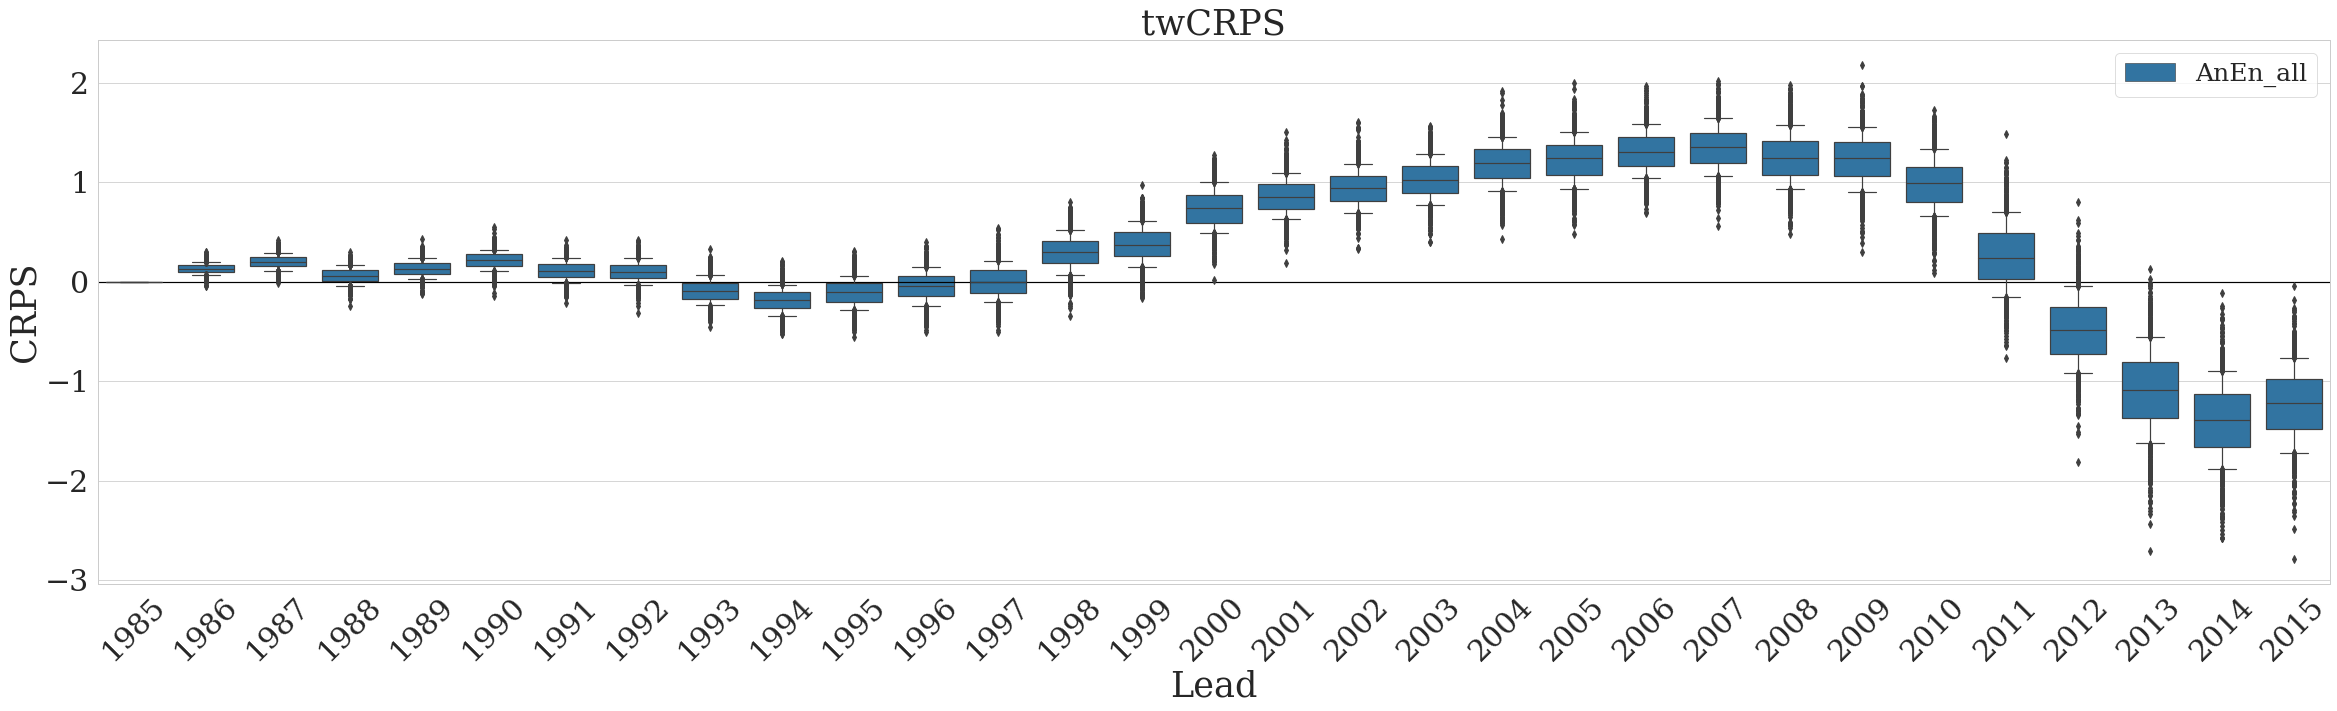

In [130]:
plt.figure(figsize=BPdict['FigSize'])
plt.plot([-10,35],[0,0],'k')

ax = sns.boxplot(x="Training Years", y="CRPS", hue="Model",data=dffin,whis=[10, 90])
plt.yticks(fontsize=BPdict['tickFS'])
plt.xticks(fontsize=BPdict['tickFS'],rotation=45)
plt.ylabel('CRPS',fontsize=BPdict['labelFS'])
plt.xlabel('Lead',fontsize=BPdict['labelFS'])
plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
plt.title('twCRPS',fontsize=BPdict['titleFS'])

# for bb in np.arange(-0.5,22,1):
#     plt.plot([bb,bb],[-.6,.2],'k--')

# plt.ylim([-.15,.21])
# plt.xlim([-0.5,10.5])
# plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_percentile'+str(percy)+'.png',dpi = 300,bbox_inches='tight')

plt.show()

doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the threshold: 286.53113403320316 for a percentile: 90
calc tw-crps
...boostrapping....
doing: F072
this is the thre

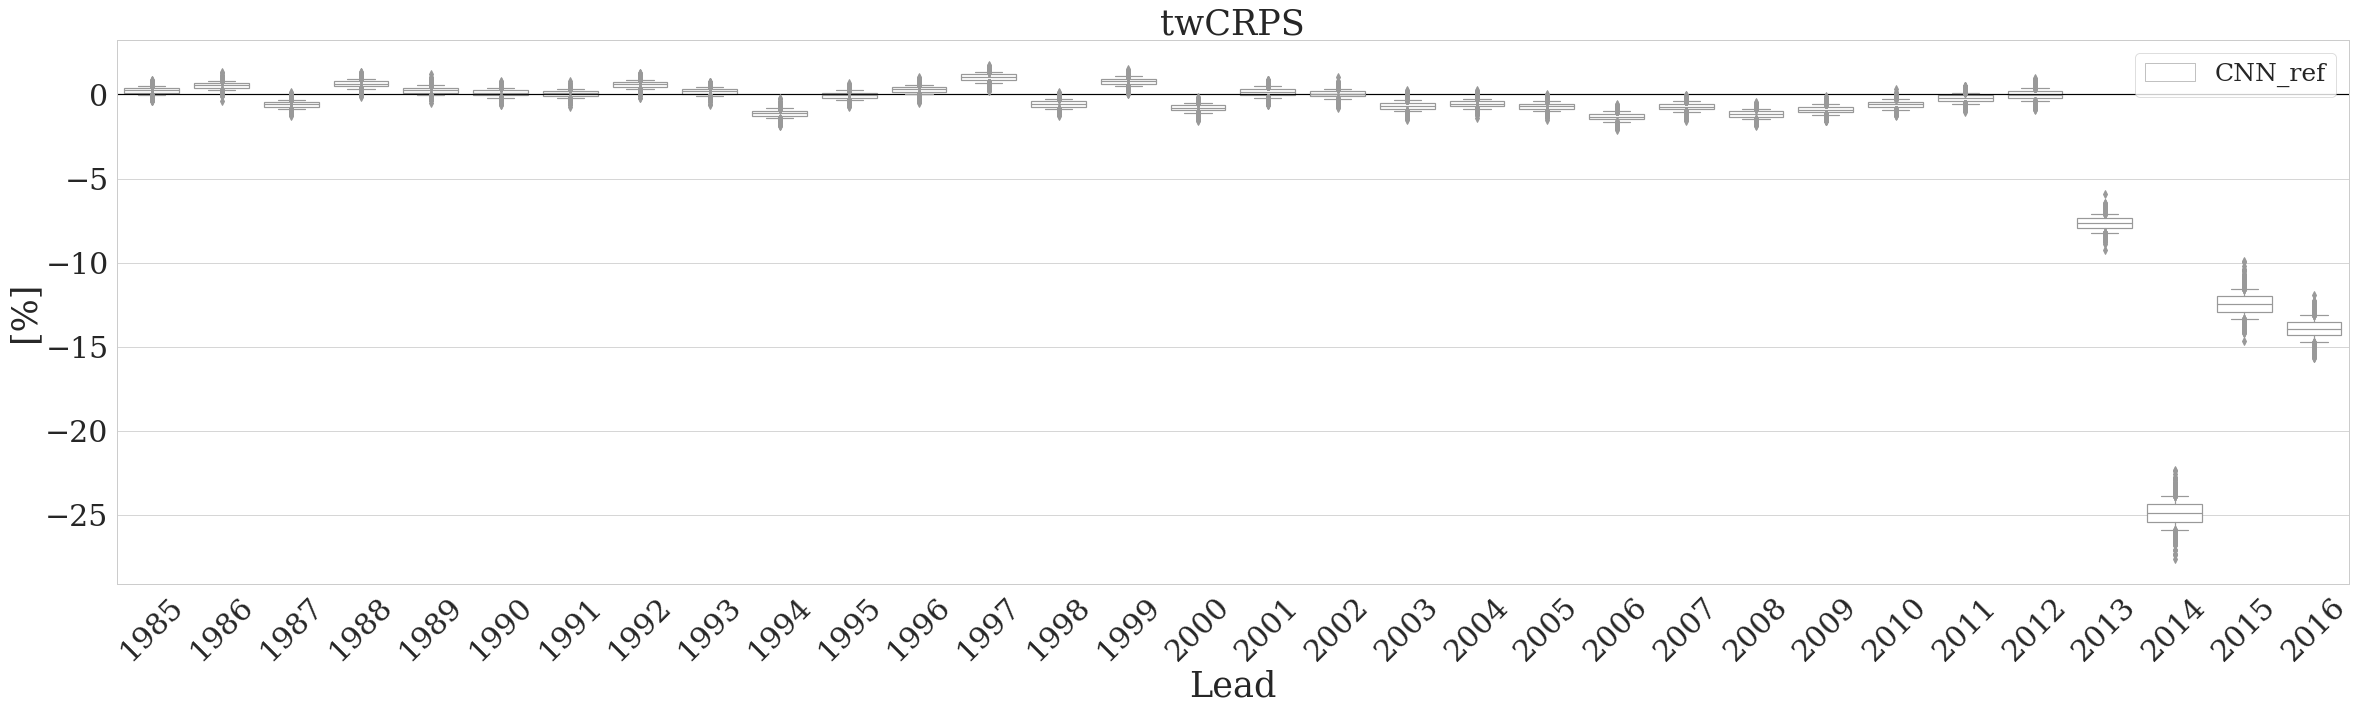

In [13]:
percy = 90
yearstot = np.arange(1985,2016,1)
training_years = np.arange(31,0,-1)
dffin=pd.DataFrame({'Training Years':[],'Model':[],'CRPS':[]})
df2,df4,dfm=1,1,1
fcasts = ['F'+f'{bb:03}' for bb in np.arange(0,126,6)]
fcasts = ['F072']
bsnummy = 1000
ense = 100


for fcast in fcasts:
    dffin=pd.DataFrame({'Training Years':[],'Model':[],'CRPS':[]})
    for indyy,yearz in enumerate(pd.date_range("1985", periods=32, freq="Y").year.astype('str').tolist()):
        del df2
        del df4 
        
        print('doing:',fcast)
        fortts=np.array([])
        mods = ['CNNft_ref']
        for mod in mods:
            df,Pre_m, Pre_s, Post_m, Post_s, Obs =utils_verif.load_forecast(fcast,mod)
            fortts=np.concatenate([fortts,np.array(Post_m)])
            bounds =[]
            threshold = np.percentile(fortts,percy)
        ##############
        print("this is the threshold:",threshold,'for a percentile:', percy)
        ########################################################################################################
        
        mod = 'CNNft_ref'
        df4,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_verif.load_forecast(fcast,mod)
        df4 = df4.rename(columns={'OBS':'OBScnn','Model':'Reforecast_CNN','IVTmean':'IVTmean_CNN','IVTstd':'IVTstd_CNN'})
        
        
        df2,Pre_m, Pre_s, Post_m, Post_s, Obs = utils_CNN.load_forecast(fcast,yearz)
        df2 = df2.rename(columns={'OBS':'OBScnn2','Model':'Reforecast_CNN2','IVTmean':'IVTmean_CNN2','IVTstd':'IVTstd_CNN2'})
        
        dfm = pd.merge(df4,df2,how='left')
        #define 4 groups:
        
        Merrac = dfm['OBScnn']
        For_uc = dfm['IVTmean_CNN']
        For_sc = dfm['IVTstd_CNN']
    
        Merrac2 = dfm['OBScnn2']
        For_uc2 = dfm['IVTmean_CNN2']
        For_sc2 = dfm['IVTstd_CNN2']
    

        #aadefine 4 groups:
       
        Ensemblc = np.zeros([Merrac.shape[0],ense])
        Truthc = np.zeros([Merrac.shape[0]])
        
        Ensemblc2 = np.zeros([Merrac2.shape[0],ense])
        Truthc2 = np.zeros([Merrac2.shape[0]])
        
        
        for gre in range(Merrac.shape[0]):
            Ensemblc[gre,:]=np.random.normal(For_uc[gre],For_sc[gre],100)
            Truthc[gre] = Merrac[gre]
            Ensemblc2[gre,:]=np.random.normal(For_uc2[gre],For_sc2[gre],100)
            Truthc2[gre] = Merrac2[gre]
            
                
        CRPStempc = np.zeros((Merrac.shape[0]))
        CRPStempc2 = np.zeros((Merrac2.shape[0]))
    
        print('calc tw-crps')

        for gre in range(0,Merrac.shape[0]):    
            if np.max(np.append(Merrac[gre],Ensemblc[gre,:]))<=threshold:
                CRPStempc[gre] = 0
            else:
                CRPStempc[gre] = twcrps_sample2(Merrac[gre],Ensemblc[gre,:],'indicator.right',threshold,step_width=10)
    
    
        for gre in range(0,Merrac2.shape[0]):    
            if np.max(np.append(Merrac2[gre],Ensemblc2[gre,:]))<=threshold:
                CRPStempc2[gre] = 0
            else:
                CRPStempc2[gre] = twcrps_sample2(Merrac2[gre],Ensemblc2[gre,:],'indicator.right',threshold,step_width=10)
    
    
        print("...boostrapping....")
#     bootstrap randomdraws:
        CRPScnn_ref = np.zeros(bsnummy)
        CRPScnn_ref2 = np.zeros(bsnummy)
        
        
        for bb in range(bsnummy):
            inss = np.random.randint(Merrac2.shape[0], size=Merrac2.shape[0])
            CRPScnn_ref[bb] = (1 - (np.mean(CRPStempc2[inss])/np.mean(CRPStempc[inss])))*100
#             CRPScnn_ref[bb] = np.mean(CRPStempc[inss])
#             CRPScnn_ref2[bb] = ((np.mean(CRPStempc2[inss])))
            
#             CRPScnn_ref[bb] = (1 - (np.mean(CRPStempc2[inss])/np.mean(CRPStempc[inss])))*100
#             CRPScnn_ref[bb] = np.mean(CRPStempc2[inss])
    
        
        #define 3 groups:  
    
        dftemp = pd.DataFrame({'CRPS':CRPScnn_ref})
        dftemp['Training Years'] = str(yearz)
        dftemp['Model'] = 'CNN_ref'
        dffin = pd.concat([dffin, dftemp], axis=0)
    
    plt.figure(figsize=BPdict['FigSize'])
    plt.plot([-10,35],[0,0],'k')

    ax = sns.boxplot(x="Training Years", y="CRPS", hue="Model",data=dffin,palette=mycolors,whis=[10, 90])
    plt.yticks(fontsize=BPdict['tickFS'])
    plt.xticks(fontsize=BPdict['tickFS'],rotation=45)
    plt.ylabel('[%]',fontsize=BPdict['labelFS'])
    plt.xlabel('Lead',fontsize=BPdict['labelFS'])
    plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
    plt.title('twCRPS',fontsize=BPdict['titleFS'])
    plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_CNN_By_Year_'+fcast+'_Perc_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')
    plt.show() 
    break
        

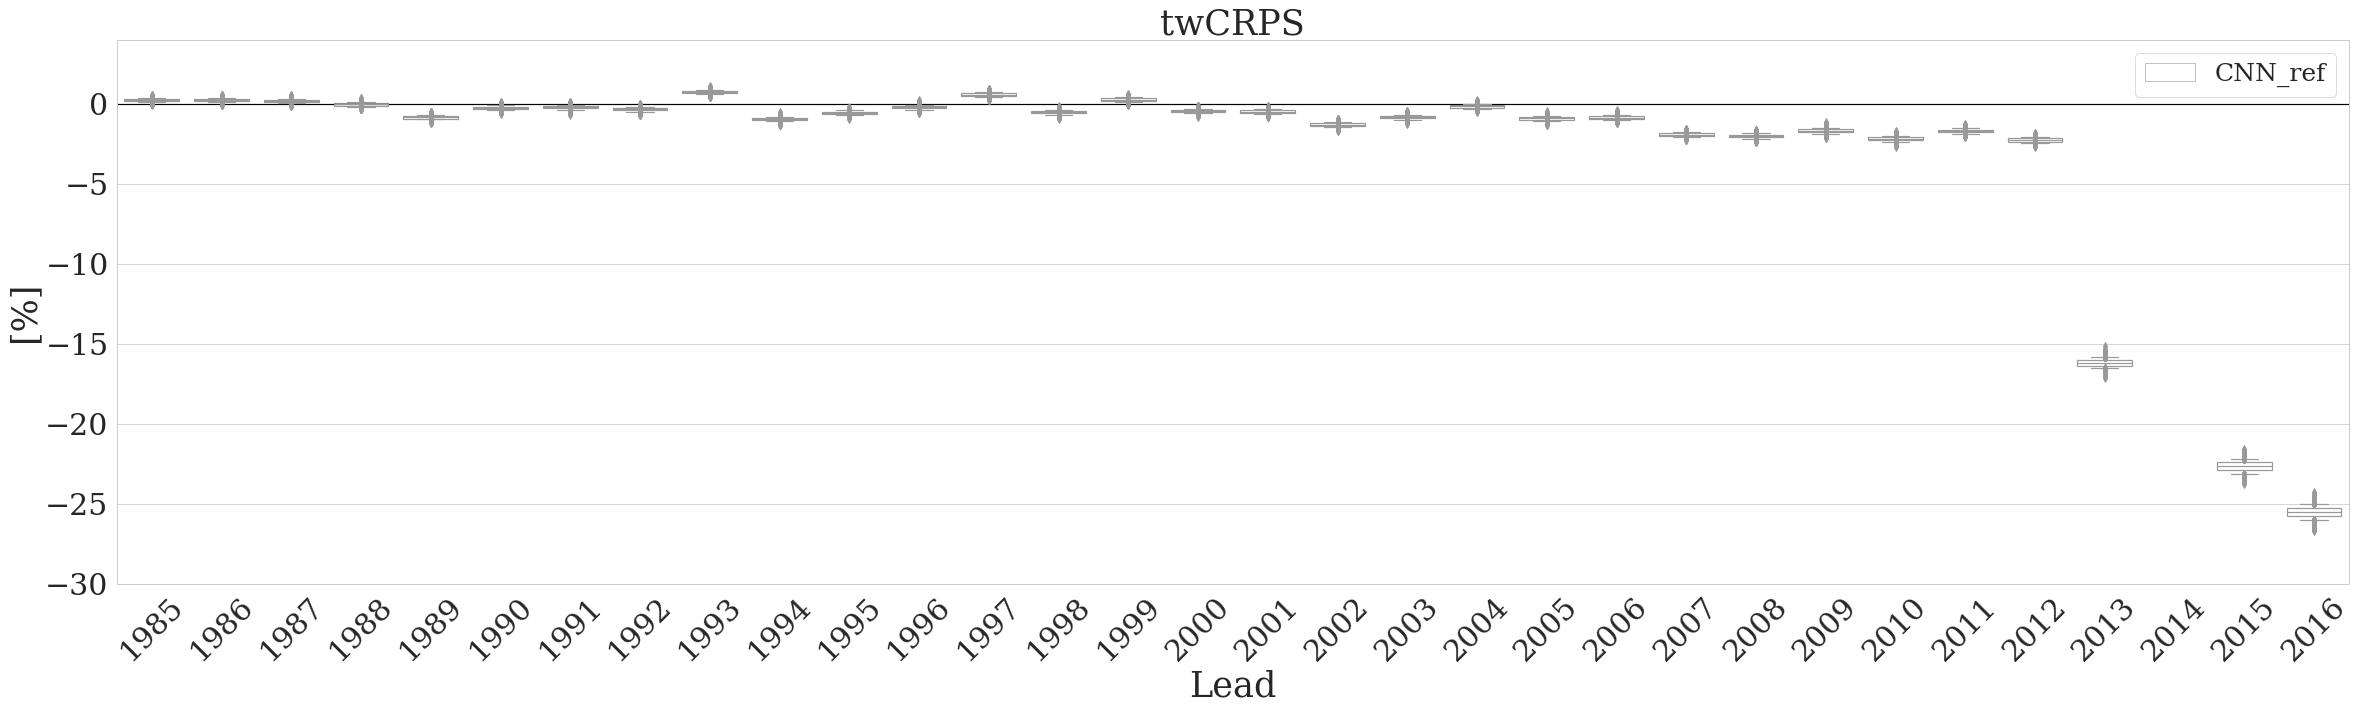

In [12]:
plt.figure(figsize=BPdict['FigSize'])
plt.plot([-10,35],[0,0],'k')

ax = sns.boxplot(x="Training Years", y="CRPS", hue="Model",data=dffin,palette=mycolors,whis=[10, 90])
plt.yticks(fontsize=BPdict['tickFS'])
plt.xticks(fontsize=BPdict['tickFS'],rotation=45)
plt.ylabel('[%]',fontsize=BPdict['labelFS'])
plt.xlabel('Lead',fontsize=BPdict['labelFS'])
plt.legend(fontsize=BPdict['legendFS'],loc='upper right')
plt.title('twCRPS',fontsize=BPdict['titleFS'])
plt.savefig('/glade/work/wchapman/AnEn/CNN/Coastal_Points_LogNormal/Figures/TWCRPS_CNN_By_Year_'+fcast+'_Perc_'+str(percy)+'.png',dpi = 300,bbox_inches='tight')
plt.ylim([-30,4])
plt.show() 